# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

В нашем распоряжении **исторические данные**: технические характеристики, комплектации и цены автомобилей. 

Нам нужно **построить модель для определения стоимости**. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки **качества моделей** применяем метрику `RMSE`.

## Этапы выполнения проекта:

1. Загрузить и подготовить данные.
2. Обучить разные модели, для каждой попробовать различные гиперпараметры.
3. Проанализировать скорость работы и качество моделей.

## Подготовка данных

Загрузим необходимые для работы библиотеки.

In [1]:
!python.exe -m pip install --upgrade pip --user -q

In [2]:
!pip install sidetable -q
!pip install inflection -q
!pip install category_encoders -q
!pip install catboost -q
!pip install lightgbm -q

In [3]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import time

import sidetable
import inflection

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import category_encoders as ce

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.dummy import DummyRegressor

In [4]:
import warnings
warnings.filterwarnings("ignore")

Создаем путь к файлу с данными.

In [5]:
path = '/datasets/autos.csv'

Сохраним файл в переменную.

In [6]:
try:
    df = pd.read_csv(path)
except Exception as err:
    try:
        df = pd.read_csv(path[10:])
    except Exception as err:
        print('Ошибка чтения файла df:', repr(err))

Ознакомимся с данными.

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Видим, что названия колонок противоречат стилю *python*. Используем библиотеку `Inflection` для трансформации `CamelCase` в `underscored_string`.

In [8]:
for column in df.columns:
    df = df.rename(columns={column: inflection.underscore(column)})

Проверим, что получилось.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Названия столбцов изменились.

### Описание данных

**Признаки**

- `date_crawled` — дата скачивания анкеты из базы
- `vehicle_type` — тип автомобильного кузова
- `registration_year` — год регистрации автомобиля
- `gearbox` — тип коробки передач
- `power` — мощность (л. с.)
- `model` — модель автомобиля
- `kilometer` — пробег (км)
- `registration_month` — месяц регистрации автомобиля
- `fuel_type` — тип топлива
- `brand` — марка автомобиля
- `not_repaired` — была машина в ремонте или нет
- `date_created` — дата создания анкеты
- `number_of_pictures` — количество фотографий автомобиля
- `postal_code` — почтовый индекс владельца анкеты (пользователя)
- `last_seen` — дата последней активности пользователя

**Целевой признак**

- `price` — цена (евро)

- Таблица с данными представлена 354369 строчками, каждая из которой является информацией об автомобиле, и 16 колонками с техническими характеристиками, комплектацией и ценами автомобилей.


- Сразу отметим, что в таблице есть пропуски, а тип данных в колонках `date_crawled`, `date_created` и `last_seen` должен соответствовать `datetime`.

### Изменение типа данных.
Изменим тип данных.

In [10]:
columns_for_change = ['date_crawled', 'date_created', 'last_seen']

In [11]:
for column in columns_for_change:
    df[column] = pd.to_datetime(
        df[column],
        format='%Y-%m-%d %H:%M:%S'
    )
    
del columns_for_change

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

Теперь у колонок правильный тип данных.

### Оценка количества пропусков

Оценим количество пропусков в данных.

In [13]:
def display_missing(data):
    try:
        display(data.stb.missing(style=True))
    except Exception as err:
        try:
            display(data.isna().sum())
        except Exception as err:
            print('Ошибка чтения файла df:', repr(err))

In [14]:
display_missing(df)

,missing,total,percent
not_repaired,"71,154","354,369",20.08%
vehicle_type,"37,490","354,369",10.58%
fuel_type,"32,895","354,369",9.28%
gearbox,"19,833","354,369",5.60%
model,"19,705","354,369",5.56%
date_crawled,0,"354,369",0.00%
price,0,"354,369",0.00%
registration_year,0,"354,369",0.00%
power,0,"354,369",0.00%
kilometer,0,"354,369",0.00%


- Пропуски есть в пяти колонках, 20.0% пропусков в колонке с информацией о ремонте машины, по примерно 10% пропусков в двух колонках - о типах кузова и топлива, а так же в районе 6% о типе коробки передач и модели автомобиля.

### Обработка дубликатов

Проверим таблицу на явные дубликаты.

In [15]:
df.duplicated().sum()

4

In [16]:
df[df.duplicated(keep=False)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


В таблице присутсвует 4 явных дубликата, которые можно удалить.

In [17]:
df = df.drop_duplicates().reset_index(drop=True)

Так же в таблице могут попасть неявные дубликаты: клиент продублировал объявление в разные даты или поменял район проживания. Так же стоит учесть, что одну и ту же анкету можно было создавать и скачивать несколько раз, возможно с разных сайтов.

In [18]:
df.drop(columns=[
    'postal_code', # почтовый индекс владельца анкеты (пользователя)
    'last_seen', # дата последней активности пользователя
    'date_created', # дата создания анкеты
    'date_crawled' # дата скачивания анкеты из базы
], axis=1).duplicated().sum()

27539

Достаточно много неявно дублирующихся данных в таблице.

In [19]:
list_for_duplicated = []
for column in df.columns:
    if column not in ['postal_code', # почтовый индекс владельца анкеты (пользователя)
                      'last_seen', # дата последней активности пользователя
                      'date_created', # дата создания анкеты
                      'date_crawled'  # дата скачивания анкеты из базы
                     ]:
        list_for_duplicated.append(column)

In [20]:
list_for_duplicated

['price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'not_repaired',
 'number_of_pictures']

In [21]:
df = df.drop_duplicates(subset=list_for_duplicated).reset_index(drop=True)
del list_for_duplicated

- Из таблицы убрали дубликаты анкет.

### Данные в колонках

Рассмотрим подробнее данные в каждой колонке.

#### `price`  — цена (евро)

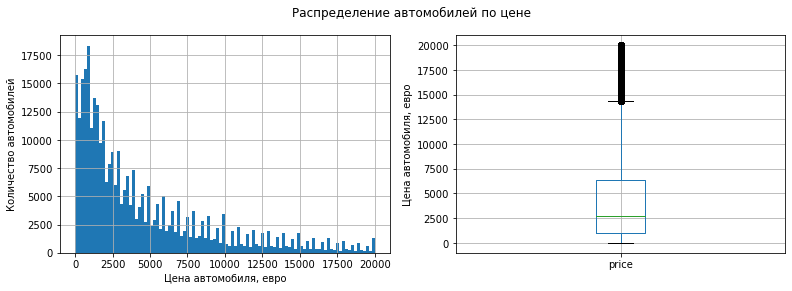

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
df['price'].hist(bins=100, ax=axes[0])
axes[0].set_xlabel('Цена автомобиля, евро')
axes[0].set_ylabel('Количество автомобилей')
plt.suptitle('Распределение автомобилей по цене')
df.boxplot(column='price', ax=axes[1])
# plt.suptitle('Диаграмма размаха по цене автомобиля')
axes[1].set_ylabel('Цена автомобиля, евро')

plt.show()


In [23]:
df.price.describe()

count    326826.000000
mean       4403.747330
std        4518.209808
min           0.000000
25%        1000.000000
50%        2700.000000
75%        6350.000000
max       20000.000000
Name: price, dtype: float64

Цена представленных подержанных автомобилей варьируется от 0 (возможно, пользователь не указал цену или произошла ошибка при выгрузке данных) до 20000 евро. Средняя цена подержанного автомобиля - 4400 евро, медианная - 2700 евро.

Хотел бы пользователь предсказывать цену автомобиля и увидеть 0? Думаем, что нет. От нулевых значений избавимся и остается вопрос - какая минимальная сумма, которую должна предсказывать модель? 

Если зайти на сайты, торгующие подержанными автомобилями, можно увидеть, как под описанием автомобиля продаются запчасти к данным автомобилям. Отсечь нижнюю границу достаточно сложно.

Взглянем на авто ниже 200 евро.

In [24]:
df[df.price < 200]['price'].count()

15761

Более 15 тысяч объявлений! Однако на любом сайте есть случаи неадекватных цен и вводящих в заблуждение объявлений.

Избавимся от цен ниже 200 евро за автомобиль - мы хотим предсказывать автомобили, а не шины.

In [25]:
df = df.query('200 < price')

#### `registration_year` — год регистрации автомобиля

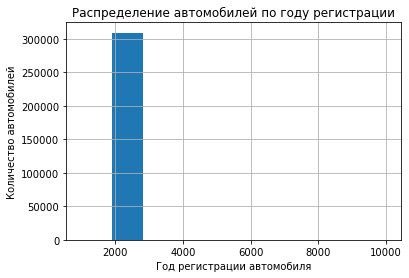

In [26]:
df['registration_year'].hist()
plt.xlabel('Год регистрации автомобиля')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по году регистрации')
plt.show()

In [27]:
df['registration_year'].describe()

count    309185.000000
mean       2003.980536
std          69.361856
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Нереалистичные данные в таблице.

Проверим их на взаимосвязь с целевым признаком.

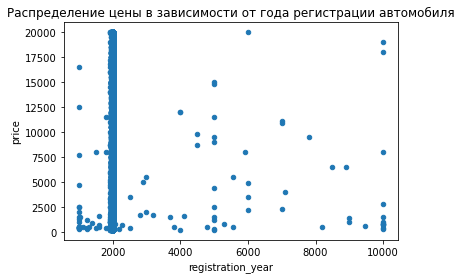

In [28]:
df.plot(x='registration_year', y='price', kind='scatter')
plt.title(f'Распределение цены в зависимости от года регистрации автомобиля')
plt.show()

Корреляция между ценой и годом регистрации автомобиля.

In [29]:
df.registration_year.corr(df.price)

0.04034339066445964

Корреляция не высока, но в таблице явно присутсвуют ложные данные. 

Поскольку заказчику важна точность предсказаний, учтем **только автомобили с 1950 по 2016 год (год выгрузки данных)**. 

Мы понимаем, что пользователь может опечататься при вводе года, но такие ошибки непрогнозируемы, пользователь может ввести любое число, как и котик, пробежавший по клавиатуре. Мы не будем закладывать такие случаи в нашу модель.

In [30]:
df = df.query('1950 <= registration_year <= 2016')

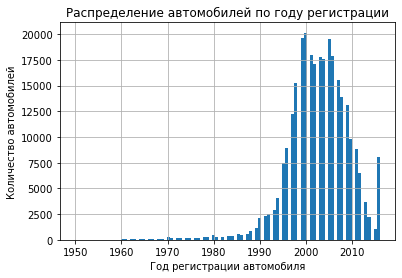

In [31]:
df['registration_year'].hist(bins=100)
plt.xlabel('Год регистрации автомобиля')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по году регистрации')
plt.show()

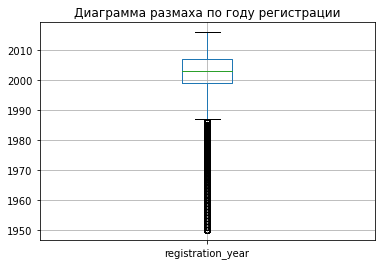

In [32]:
df.boxplot(column='registration_year')
plt.title('Диаграмма размаха по году регистрации')
plt.show()

Видим, что в данных оставляем достаточно выбросов на случай, если кто-то захочет проверить стоимость достаточно подержанного автомобиля.

Посмотрим, как изменилась зависимость цены от года регистрации.

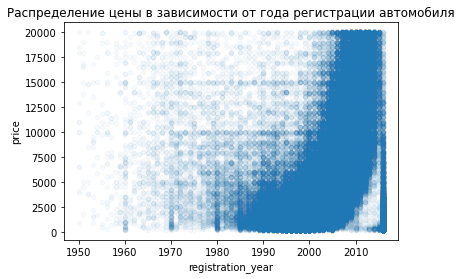

In [33]:
df.plot(x='registration_year', y='price', kind='scatter', alpha=0.03)
plt.title(f'Распределение цены в зависимости от года регистрации автомобиля')
plt.show()

In [34]:
df.registration_year.corr(df.price)

0.4414006594370194

- Удалив из таблицы "машины из машины времени", мы можем увидеть числовое увеличение корреляции, которое, однако, сложно заметить на визуальном представлении.

#### `registration_month` — месяц регистрации автомобиля

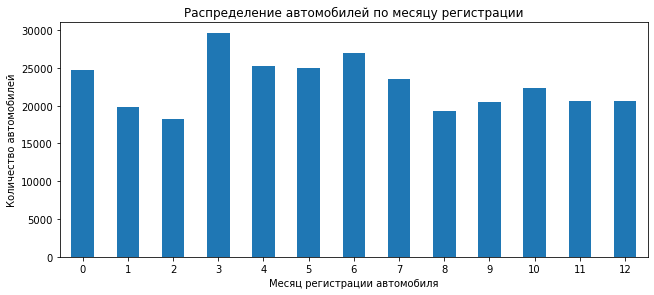

In [35]:
df.groupby('registration_month').price.count().plot(kind='bar', figsize=(9, 4), rot=0)
plt.tight_layout()

plt.xlabel('Месяц регистрации автомобиля')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по месяцу регистрации')
plt.show()

В таблице 13 месяцев. Возможное значение нуля - пользователь не указал месяц регистрации. Однако эти данные не должны помешать предсказанию модели.

Рассмотрим взаимосвязь с целевым признаком.

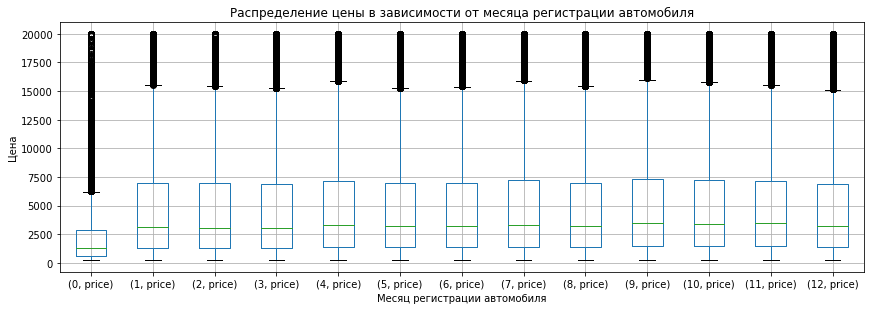

In [36]:
df.groupby('registration_month').boxplot(column='price', subplots=False, figsize=(12, 4))

plt.tight_layout()
plt.title(f'Распределение цены в зависимости от месяца регистрации автомобиля')
plt.ylabel('Цена')
plt.xlabel('Месяц регистрации автомобиля')
plt.show()

Самы низкий разброс цен у автомобилей с нулевым месяцем. 

In [37]:
df.registration_month.corr(df.price)

0.08112003888202153

Связь не видна. 

Вспоминаем запрос заказчика: приложение, в котором можно быстро узнать рыночную стоимость своего автомобиля. 

Кто-то помнит месяц регистрации своего автомобиля?

Для этого пользователю скороее всего придется поискать документы. Или поискать другое приложение, где можно будет не вспоминать месяц регистрации. 

Данные, возможно, могли бы помочь модели, но уходящие клиенты - не то, чему будет рад заказчик. Удалим эту колонку из таблицы.

In [38]:
df.drop(columns=['registration_month'], axis=1, inplace=True)

#### `vehicle_type` — тип автомобильного кузова

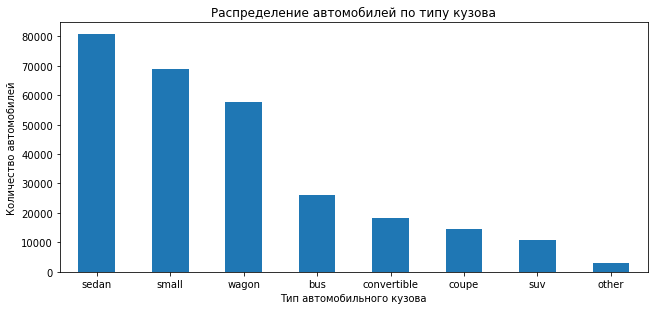

In [39]:
df['vehicle_type'].value_counts().plot(kind='bar', figsize=(9, 4), rot=0)
plt.tight_layout()

plt.xlabel('Тип автомобильного кузова')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по типу кузова')
plt.show()

Данные выглядят реалистичными.

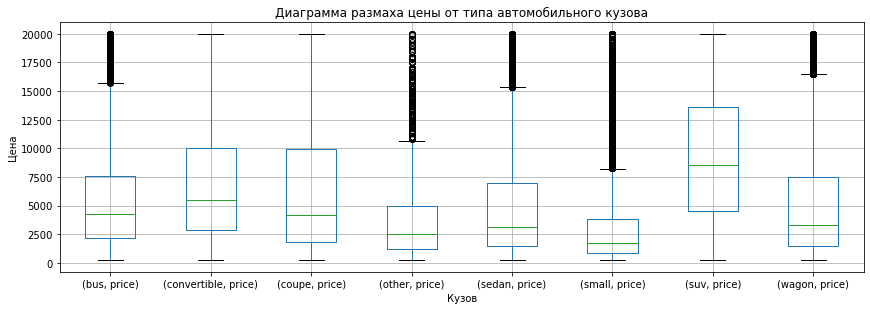

In [40]:
df.groupby('vehicle_type').boxplot(column='price', subplots=False, figsize=(12, 4))

plt.tight_layout()
plt.title('Диаграмма размаха цены от типа автомобильного кузова')
plt.ylabel('Цена')
plt.xlabel('Кузов')
plt.show()

- Цена для автомобилей варьируется в реалистичных пределах.

#### `gearbox` — тип коробки передач

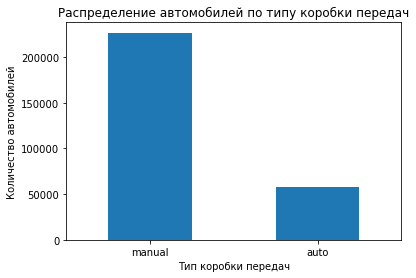

In [41]:
df['gearbox'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Тип коробки передач')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по типу коробки передач')
plt.show()

Данные выглядят реалистичными.

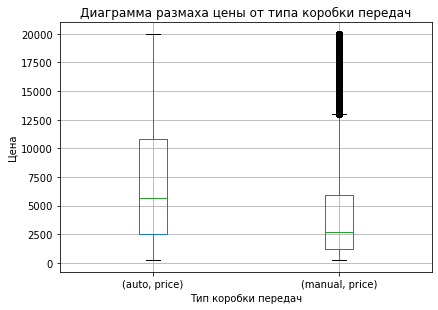

In [42]:
df.groupby('gearbox').boxplot(column='price', subplots=False, 
#                               figsize=(12, 4)
                             )

plt.tight_layout()
plt.title('Диаграмма размаха цены от типа коробки передач')
plt.ylabel('Цена')
plt.xlabel('Тип коробки передач')
plt.show()

У автоматической коробки передач диапазон цен шире и выше медианное значение.

#### `fuel_type` — тип топлива

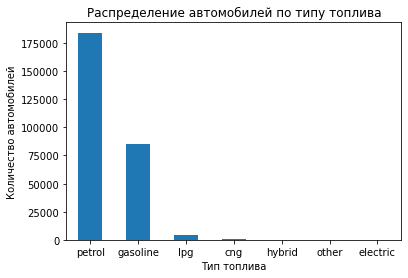

In [43]:
df['fuel_type'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Тип топлива')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по типу топлива')
plt.show()

- *Petrol* и *gasoline* [обозначают одно и то же](https://www.quora.com/What-is-the-difference-between-gasoline-and-petrol) - бензин - неявные дубликаты в колонке, которые стоит привести к единому значению.

Разберемся в остальных обозначениях.
- *cng* (compressed natural gas) – сжатый природный газ (метан): газообразные углеводороды, образующиеся в земной коре, высокоэкономичное энергетическое топливо.
- *lpg* (liquified petroleum gas) – сжиженный газ (пропан-бутан). Газ, полученный при добыче и переработке нефти. В жидкое состояние переводят при охлаждении до критической температуры и последующей конденсации в результате отвода теплоты парообразования [[ссылка на источник]](https://www.drive2.ru/l/3409061/).

Поскольку газ используется разный, то оставим эти значения как есть.

Объединим *petrol* и *gasoline*.

In [44]:
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')

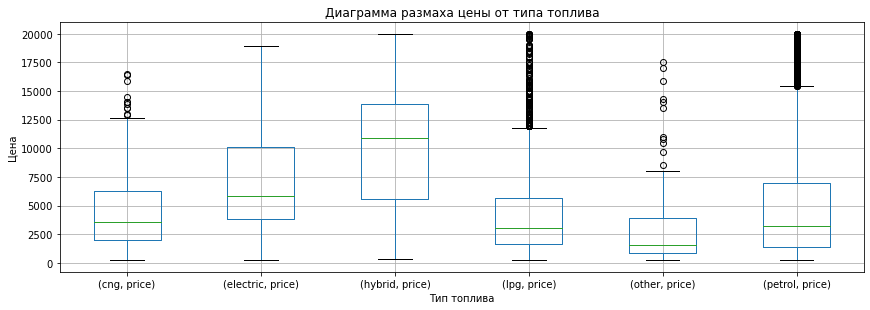

In [45]:
df.groupby('fuel_type').boxplot(column='price', subplots=False, 
                              figsize=(12, 4)
                             )

plt.tight_layout()
plt.title('Диаграмма размаха цены от типа топлива')
plt.ylabel('Цена')
plt.xlabel('Тип топлива')
plt.show()

Машины-гибриды ожидаемо имеют самые высокие цены.

#### `power` — мощность (л. с.)


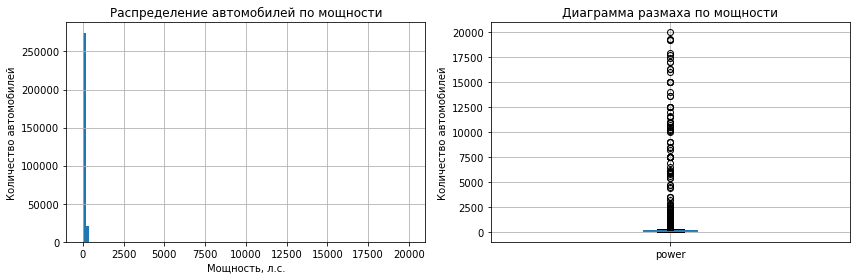

In [46]:
def power_show(bins=100):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    df['power'].hist(bins=bins, ax=axes[0])

    axes[0].set_xlabel('Мощность, л.с.')
    axes[0].set_ylabel('Количество автомобилей')
    axes[0].set_title('Распределение автомобилей по мощности')


    df.boxplot(column='power', ax=axes[1])
    axes[1].set_title('Диаграмма размаха по мощности')
    axes[1].set_ylabel('Количество автомобилей')

    plt.tight_layout()

    plt.show()
    
power_show()

In [47]:
df['power'].describe()

count    296119.000000
mean        113.463780
std         189.730542
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Машина с минимальной мощностью не едет, а с максимальной, возможно, способна покинуть орбиту Земли. Мы понимаем, что не каждый указывает мощность своего автомобиля в анкете, но в таблице пропусков в данной колонке нет, только нереалистичные значения. 

Разберемся, какова же реальная мощность автомобилей.

- Согласно [источнику](https://avto-flot.ru/blog/skolko-loshadok-doljno-byit-v-sovremennom-avto-vyibiraem-po-moschnosti.html) для **малого класса** оптимальным комплектом лошадиных сил считается мощность от **80 до 110 л.с.**, количество л.с в **элитных седанах** колеблется от **120 до 500**. 

- [Источник](https://www.drivenn.ru/journal/novosti/skolko-loshadinyh-sil-dostatochno-voditelyu-dlya-komfortnoy-ezdy-id31027) утверждает, что **средняя мощность** обыкновенного легкового автомобиля составляет около **120 л.с.**

- В [топе **самых мощных автомобилей** планеты по л.с.](https://cars-rating.ru/legkovye/samye-moshhnye-avtomobili-v-mire#Devel_Sixteen_5000) указаны автомобили с мощностью **1100-1600 и даже 2500 и 5000 л.с.**

- Известный автомобиль [ГАЗ-М20 **«Победа»**](https://carakoom.com/blog/27-legendarnyh-sovetskih-avtomobilej-na-chyom-ezdili-v-sssr) второй серии, выпуск которой продолжался с 1948 по 1955 год, получил обновленный 4-цилиндровый двигатель мощностью **50 л.с.** (с 1955 г — **52 л.с.**).

Теперь мы представляем примерный реальный разброс.

Посмотрим на зависимость цены от мощности автомобиля.

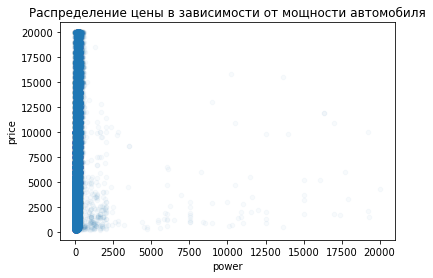

In [48]:
df.plot(x='power', y='price', kind='scatter', alpha=0.03)
plt.title(f'Распределение цены в зависимости от мощности автомобиля')
plt.show()

In [49]:
df.power.corr(df.price)

0.15405426052883486

Зависимость на непочищенных данных невысокая.

Заказчику важна точность, поэтому мы не обучаем модель на заведомо ложных данных.

Ограничимся мощностью в 50-500 л.с.

In [50]:
df = df.query('50 <= power <= 500')

И проверим заново распределение значений мощности.

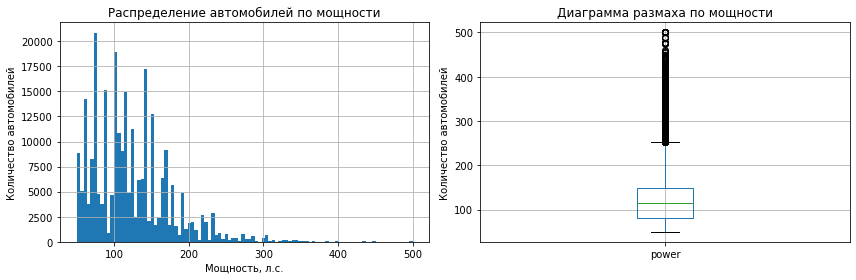

In [51]:
power_show()

Мы захватили большое количество выбросов, но это могут быть вполне реальные значения. Проверим, так ли это. Рассмотрим несколько автомобилей с мощностью выше 490 л.с.

In [52]:
df[df.power > 490].tail()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
259324,2016-04-03 01:56:57,9500,small,1992,manual,500,NaN,5000,NaN,volkswagen,no,2016-04-03,0,26388,2016-04-07 09:44:44
282515,2016-03-06 16:06:35,14999,coupe,2006,auto,500,other,150000,petrol,mercedes_benz,no,2016-03-06,0,60386,2016-03-10 04:44:59
285958,2016-03-22 18:37:41,18999,convertible,2002,auto,500,sl,100000,petrol,mercedes_benz,no,2016-03-22,0,44867,2016-03-22 18:37:41
319283,2016-03-22 16:52:40,15999,convertible,2004,auto,500,sl,150000,petrol,mercedes_benz,yes,2016-03-22,0,22113,2016-04-06 07:17:53
322031,2016-03-25 22:37:13,19780,wagon,2003,auto,500,e_klasse,150000,petrol,mercedes_benz,no,2016-03-25,0,32105,2016-03-26 00:51:17


В список попали 4 машины 2002-2006 гг. марки "Мерседес" , и старенький "Фольцваген" 1992 г. 
Возможно, в данные остались неточности.

Проверим взаимосвязь с целевым признаком.

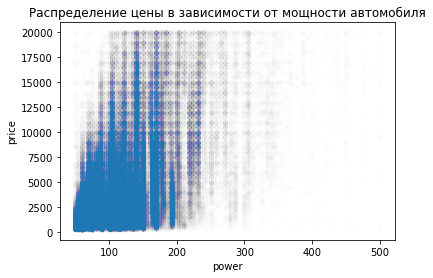

In [53]:
df.plot(x='power', y='price', kind='scatter', alpha=0.002)
plt.title(f'Распределение цены в зависимости от мощности автомобиля')
plt.show()

In [54]:
df.power.corr(df.price)

0.49817432879824464

Корреляция между мощностью и ценой на почищенных данных выросла.

#### `brand` — марка автомобиля

Посмотрим, сколько уникальных марок автомобиля представлено в таблице.

In [55]:
len(df['brand'].unique())

40

В таблице представлено достаточно много марок автомобилей.

In [56]:
for i in sorted(df['brand'].unique()):
    print(i, end=' | ')

alfa_romeo | audi | bmw | chevrolet | chrysler | citroen | dacia | daewoo | daihatsu | fiat | ford | honda | hyundai | jaguar | jeep | kia | lada | lancia | land_rover | mazda | mercedes_benz | mini | mitsubishi | nissan | opel | peugeot | porsche | renault | rover | saab | seat | skoda | smart | sonstige_autos | subaru | suzuki | toyota | trabant | volkswagen | volvo | 

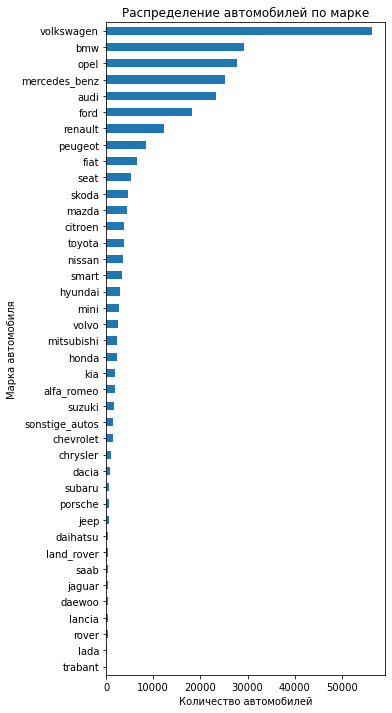

In [57]:
df['brand'].value_counts(ascending=True).plot(kind='barh', rot=0, 
                                                       figsize=(5, 12)
                                                      )
plt.ylabel('Марка автомобиля')
plt.xlabel('Количество автомобилей')
plt.title('Распределение автомобилей по марке')
plt.show()

In [58]:
df['brand'].value_counts(ascending=True).tail(5).index

Index(['audi', 'mercedes_benz', 'opel', 'bmw', 'volkswagen'], dtype='object')

Самые распространенные марки автомобилей в таблице:
- Фольцваген
- БМВ
- Опель
- Мерседес Бенц
- Ауди

#### `model` — модель автомобиля

Посмотрим, сколько уникальных моделей автомобиля представлено в таблице.

In [59]:
len(df['model'].unique())

250

Достаточно много, чтобы визуализироать их все, поэтому взглянем только на наиболее распространенные в таблице модели.

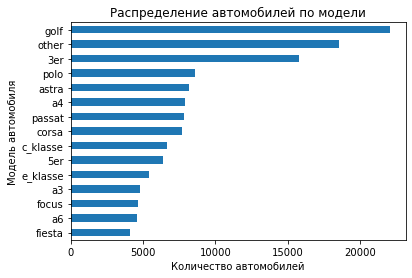

In [60]:
df['model'].value_counts(ascending=True).tail(15).plot(kind='barh', rot=0, 
#                                                        figsize=(5, 5)
                                                      )
plt.ylabel('Модель автомобиля')
plt.xlabel('Количество автомобилей')
plt.title('Распределение автомобилей по модели')
plt.show()

In [61]:
df['model'].isna().sum()

9811

Рассмотрение представленных моделей автомобиля указало на то, что в таблице есть пропущенные Nan-значения. Мы можем заполнить пропуски категорией "unknown".
<!-- значения "other" (*пер. с англ.* "другие") и  -->


In [62]:
df['model'] = df['model'].fillna('unknown')

#### `kilometer` — пробег (км)

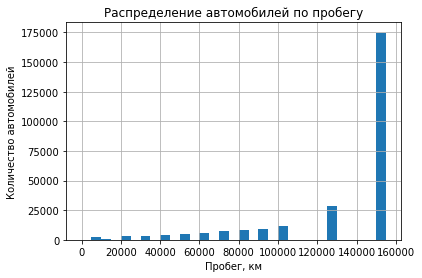

In [63]:
df['kilometer'].hist(
    bins=list(range(0, 160000, 5000))
#     bins=10
)
plt.xlabel('Пробег, км')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по пробегу')
# plt.xlim(120000, 160000)
plt.show()

In [64]:
df['kilometer'].describe()

count    263724.000000
mean     128360.539807
std       36597.666168
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Минимальный пробег автомобиля, указанный в анкете, 5000 км, максимальный (и медианный!) - 150000 км. Средним значением пробега является примерно 129000 км.

Различных значений в таблице не так много, можем посмотреть на распределение по каждому конкретному значению.

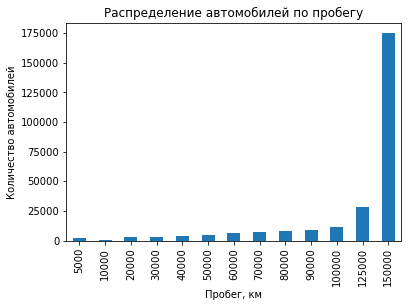

In [65]:
df.groupby('kilometer')['price'].count().plot(kind='bar')
plt.xlabel('Пробег, км')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по пробегу')
plt.show()

Как правило, [среднестатистический водитель проезжает от 10 до 30 тыс. км в год.](https://avtocod.ru/kakoj-probeg-schitaetsya-normalnym-dlya-bu-avto#:~:text=%D0%9A%D0%B0%D0%BA%20%D0%BF%D1%80%D0%B0%D0%B2%D0%B8%D0%BB%D0%BE%2C%20%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9%20%D0%B2%D0%BE%D0%B4%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%20%D0%BF%D1%80%D0%BE%D0%B5%D0%B7%D0%B6%D0%B0%D0%B5%D1%82,%D0%B8%D0%B4%D0%B5%D0%B0%D0%BB%2C%20%D0%BE%20%D0%BA%D0%BE%D1%82%D0%BE%D1%80%D0%BE%D0%BC%20%D0%BC%D0%BE%D0%B6%D0%BD%D0%BE%20%D0%BC%D0%B5%D1%87%D1%82%D0%B0%D1%82%D1%8C)
Кажется, словно большинство водителей округлили свой пробег до 150000 км.

#### `not_repaired` — была машина в ремонте или нет

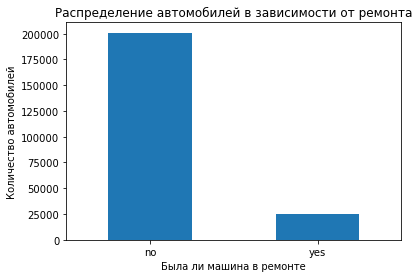

In [66]:
df['not_repaired'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Была ли машина в ремонте')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей в зависимости от ремонта')
plt.show()

In [67]:
df['not_repaired'].value_counts()

no     200870
yes     25065
Name: not_repaired, dtype: int64

Большинство автомобилей позиционируются как не нуждавшиеся в ремонте. 

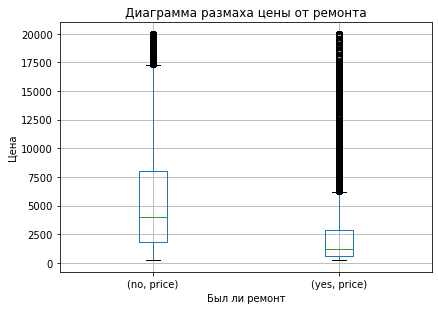

In [68]:
df.groupby('not_repaired').boxplot(column='price', subplots=False, 
#                               figsize=(12, 4)
                             )

plt.tight_layout()
plt.title('Диаграмма размаха цены от ремонта')
plt.ylabel('Цена')
plt.xlabel('Был ли ремонт')
plt.show()

Размах цены ремонтированных автомобилей ниже, так же как и ценовая медиана.

#### `number_of_pictures` — количество фотографий автомобиля

In [69]:
df['number_of_pictures'].value_counts()

0    263724
Name: number_of_pictures, dtype: int64

Ни одной фотографии автомобиля - колонка не информативна.

In [70]:
df.drop(columns=['number_of_pictures'], axis=1, inplace=True)

#### `postal_code` — почтовый индекс владельца анкеты (пользователя)

Оценим, сколько уникальных почтовых индексов владельцев анкет представлено в таблице.

In [71]:
len(df.postal_code.unique())

8103

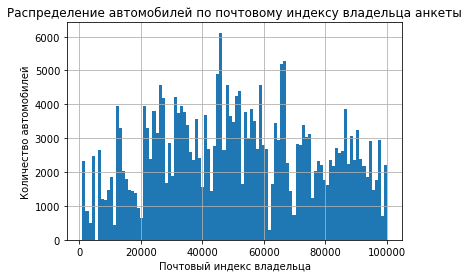

In [72]:
df.postal_code.hist(bins=100)
plt.xlabel('Почтовый индекс владельца')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по почтовому индексу владельца анкеты')
plt.show()

Почтовые индексы являются категориальной переменной - так что сравнивать их корреляцию с ценой некорректно.

#### `date_created` — дата создания анкеты


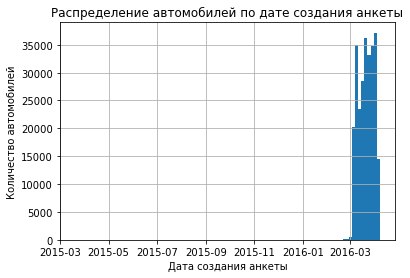

In [73]:
df.date_created.hist(
    bins=100,
#     figsize=(12, 4)
)
plt.xlabel('Дата создания анкеты')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по дате создания анкеты')
plt.show()

In [74]:
df.date_created.describe(
    datetime_is_numeric=True
)

count                           263724
mean     2016-03-20 19:19:41.216726528
min                2015-03-20 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: date_created, dtype: object

Основная масса анкет из таблицы была создана в 2016 году в марте-апреле.

Данные исторические, к тому же в таблице имеем год и месяц регистрации автомобиля, и как таковая дата создания анкеты не кажется важной для предсказания цены автомобиля, так как почти все значения укладываются в достаточно узкий промежуток времени - два месяца 2016 года, то есть не наложится фактор влияния инфляции и прочие временные изменения.

#### `date_crawled` — дата скачивания анкеты из базы

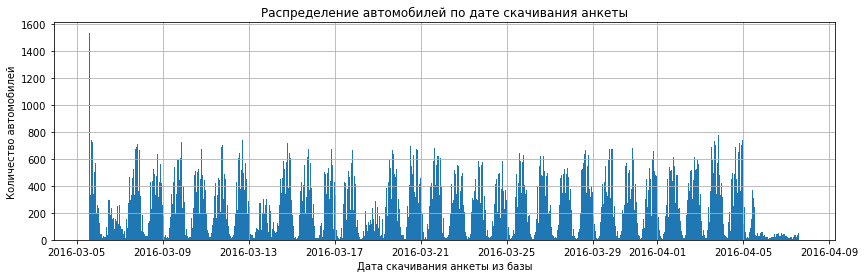

In [75]:
df.date_crawled.hist(
    bins=1000,
    figsize=(14, 4)
)
plt.xlabel('Дата скачивания анкеты из базы')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по дате скачивания анкеты')
plt.show()

In [76]:
df.date_crawled.describe(datetime_is_numeric=True)

count                           263724
mean     2016-03-21 13:03:22.973377280
min                2016-03-05 14:06:24
25%         2016-03-13 09:37:13.500000
50%         2016-03-21 17:49:50.500000
75%                2016-03-29 15:38:17
max                2016-04-07 14:36:58
Name: date_crawled, dtype: object

Анкеты скачивались кроулером каждый день в марте-апреле 2016 года.

#### `last_seen` — дата последней активности пользователя

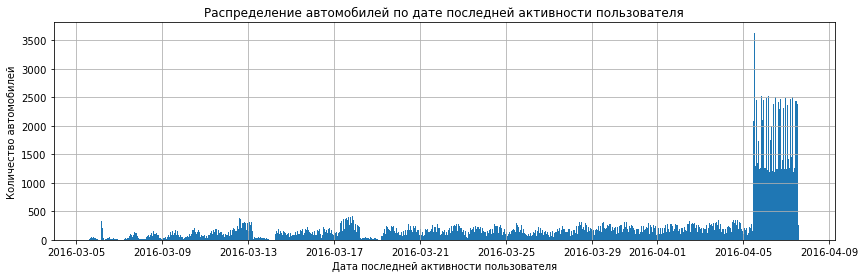

In [77]:
df.last_seen.hist(
    bins=1000,
    figsize=(14, 4)
)
plt.xlabel('Дата последней активности пользователя')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по дате последней активности пользователя')
plt.show()

In [78]:
df.last_seen.describe(datetime_is_numeric=True)

count                           263724
mean     2016-03-30 08:25:41.806710784
min                2016-03-05 14:15:08
25%                2016-03-23 18:18:28
50%                2016-04-04 12:46:19
75%                2016-04-06 11:17:49
max                2016-04-07 14:58:51
Name: last_seen, dtype: object

Пользователи в таблице последний раз были активны также в марте-апреле 2016.

**Осмысление необходимости признаков при работе модели**

Будут ли временные признаки (три последних рассмотренных признака) доступны нам при работе модели в реальном времени при настоящей работе? 

Сервис по продаже автомобилей с пробегом, для которого мы создаем приложение, хочет, чтобы пользователи могли быстро узнать рыночную стоимость своего автомобиля. 

Соответственно исторические данные за конкретные числа 2016 года нам не помогут в работе модели.

Удалим эти данные и не будем перегружать модели лишней информацией.

In [79]:
df.drop(columns=['date_created', 'date_crawled', 'last_seen'], axis=1, inplace=True)

Так же предположим, что цена не должна зависеть от почтового индекса владельца анкеты. Мы понимаем, что есть региональные различия в цене, но хотим, чтобы любой пользователь независимо от своего почтового индекса мог узнать рыночную стоимость.

In [80]:
df.drop(columns=['postal_code'], axis=1, inplace=True)

### Проверка пропусков на случайность

Посмотрим, сколько пропусков осталось после проведенной предобработки.

In [81]:
display_missing(df)

,missing,total,percent
not_repaired,"37,789","263,724",14.33%
fuel_type,"13,760","263,724",5.22%
vehicle_type,"9,546","263,724",3.62%
gearbox,"4,526","263,724",1.72%
price,0,"263,724",0.00%
registration_year,0,"263,724",0.00%
power,0,"263,724",0.00%
model,0,"263,724",0.00%
kilometer,0,"263,724",0.00%
brand,0,"263,724",0.00%


Проверим пропуски на случайность.

Для начала создадим списки признаков, по которым будем проверять случайность пропусков.

In [82]:
bar_columns_miss = ['vehicle_type', 'fuel_type', 'gearbox', 'not_repaired']
bar_columns_reduced = ['model', 'brand']
bar_columns = ['kilometer']  # here 'registration_month' was

hist_columns = ['price', 'power', 'registration_year']

Напишем формулы для визуализации проверки пропусков на случайность.

In [83]:
def show_bars_from_missed(shown_column):
    for column in bar_columns_miss:
        if shown_column is not column:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            df[df[shown_column].isna()][column].value_counts().plot(kind='bar', ax=axes[0], color='r', label='с пропусками')
            df[~df[shown_column].isna()][column].value_counts().plot(kind='bar', ax=axes[1], color='g', label='без пропусков')
            axes[0].set_xlabel(column)
            axes[0].set_ylabel('Количество автомобилей')
            axes[1].set_xlabel(column)
            axes[1].set_ylabel('Количество автомобилей')
            plt.suptitle(f'Распределение автомобилей по колонке {column} с пропусками в колонке {shown_column}')
            plt.tight_layout()
            axes[0].legend()
            axes[1].legend()
            plt.show()

In [84]:
def show_bars_from_reduced(shown_column):
    for column in bar_columns_reduced:
        fig, axes = plt.subplots(1, 2, figsize=(13, 4))
        df[df[shown_column].isna()][column].value_counts(ascending=True).tail(15).plot(kind='barh', ax=axes[0], color='r', label='с пропусками')
        df[~df[shown_column].isna()][column].value_counts(ascending=True).tail(15).plot(kind='barh', ax=axes[1], color='g', label='без пропусков')
        axes[0].set_ylabel(column)
        axes[0].set_xlabel('Количество автомобилей')
        axes[1].set_ylabel(column)
        axes[1].set_xlabel('Количество автомобилей')
        plt.suptitle(f'Распределение автомобилей по колонке {column} с пропусками в колонке {shown_column}')
        plt.tight_layout()
        axes[0].legend()
        axes[1].legend()
        plt.show()

In [85]:
def show_bars(shown_column):
    for column in bar_columns:
        fig, axes = plt.subplots(1, 2, figsize=(13, 4))
        df[df[shown_column].isna()][column].value_counts().plot(kind='bar', ax=axes[0], color='r', label='с пропусками')
        df[~df[shown_column].isna()][column].value_counts().plot(kind='bar', ax=axes[1], color='g', label='без пропусков')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Количество автомобилей')
        axes[1].set_xlabel(column)
        axes[1].set_ylabel('Количество автомобилей')
        plt.suptitle(f'Распределение автомобилей по колонке {column} с пропусками в колонке {shown_column}')
        plt.tight_layout()
        axes[0].legend()
        axes[1].legend()
        plt.show()

In [86]:
def show_hists(shown_column):
    for column in hist_columns:
        fig, axes = plt.subplots(1, 2, figsize=(13, 4))
        df[df[shown_column].isna()][column].hist(bins=100, ax=axes[0], color='r', label='с пропусками')
        df[~df[shown_column].isna()][column].hist(bins=100, ax=axes[1], color='g', label='без пропусков')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Количество автомобилей')
        axes[1].set_xlabel(column)
        axes[1].set_ylabel('Количество автомобилей')
        plt.suptitle(f'Распределение автомобилей по колонке {column} с пропусками в колонке {shown_column}')
        plt.tight_layout()
        axes[0].legend()
        axes[1].legend()
        plt.show()

#### `not_repaired` — была машина в ремонте или нет

Проверим пропуски на случайность для данного признака.

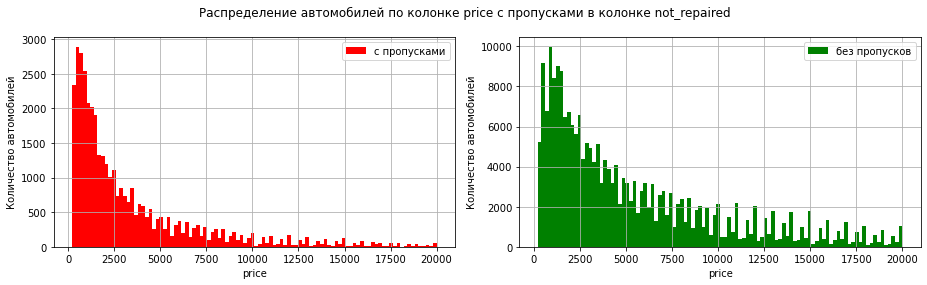

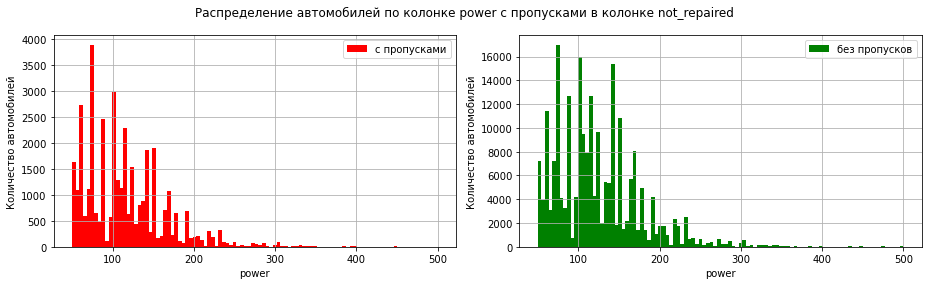

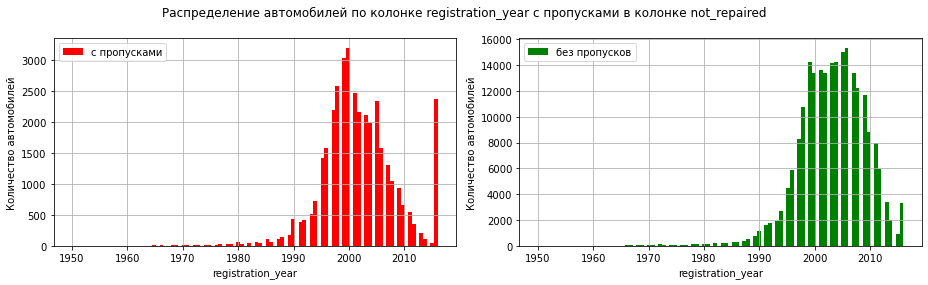

In [87]:
show_hists('not_repaired')

Внимательно посмотрев на графики распределения автомобилей с пропусками в данных о ремонте и без в зависимости от года регистрации можно отметить, что для владельцев автомобилей последних лет характерен пик отсутсвия информации про ремонт. Возможно, машины не успели побывать в ремонте за несколько лет использования.

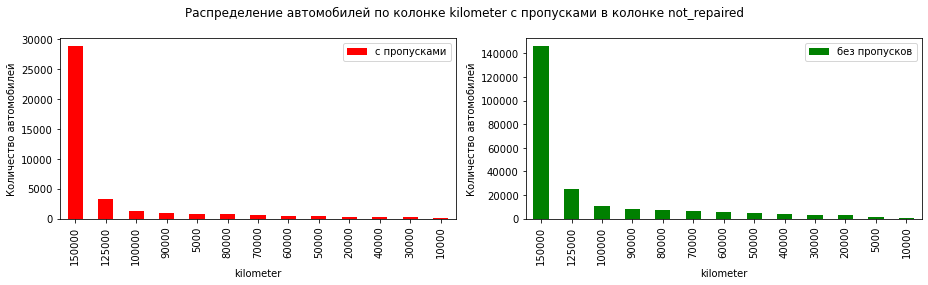

In [88]:
show_bars('not_repaired')

Так же отметим и то, что пик отсутсвующей информации о ремонте характерен для автомобилей с максимальным пробегом, что абсолютно нормально - больше авто, больше пропусков. 
<!-- нулевым месяцем регистрации автомобиля. -->

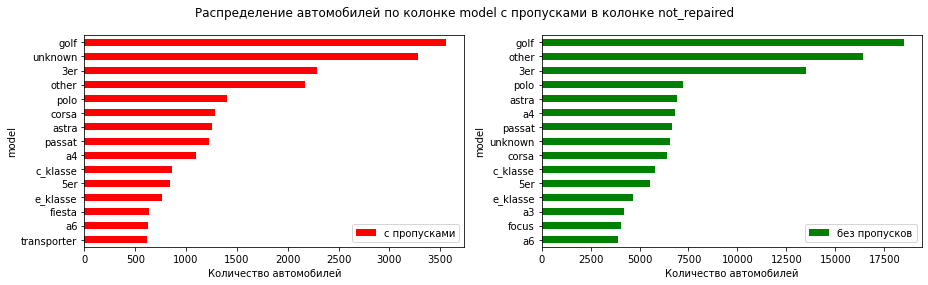

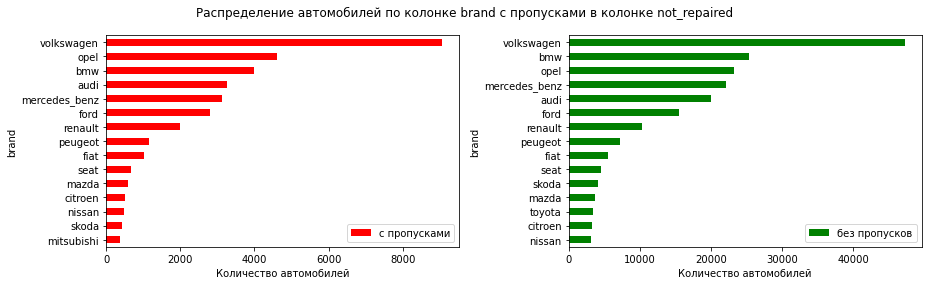

In [89]:
show_bars_from_reduced('not_repaired')

Нет зависимости пропусков в колонке с ремонтом от марки и модели автомобиля, кроме того факта, что у машин неизвестных моделей много пропусков.

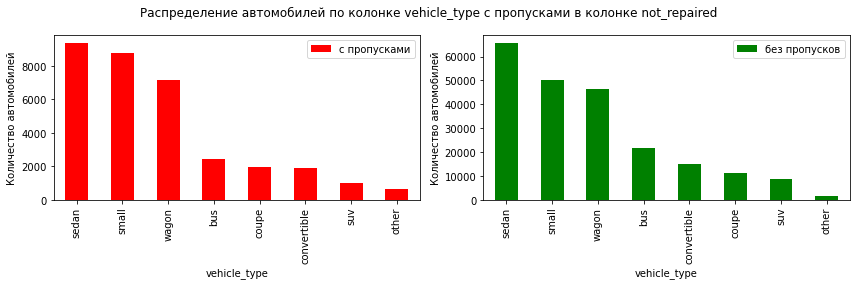

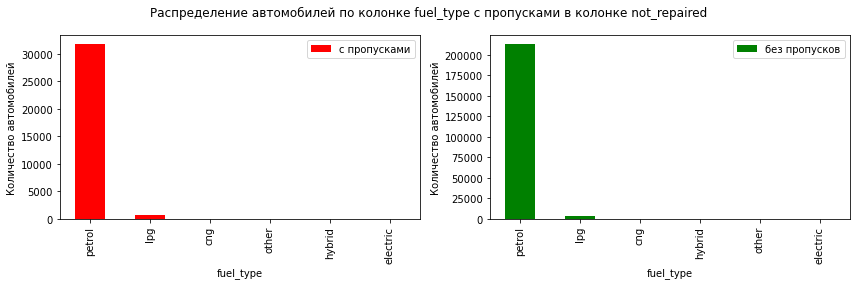

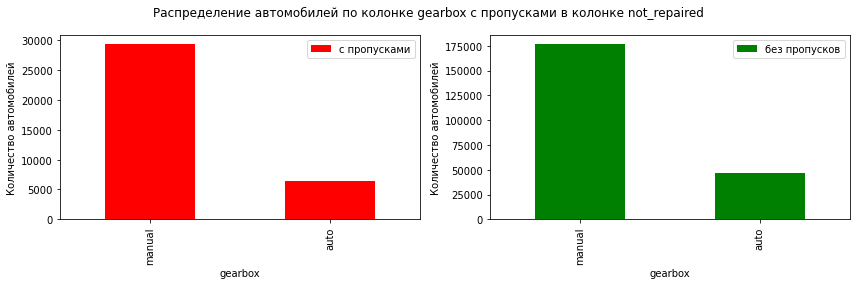

In [90]:
show_bars_from_missed('not_repaired')

Зависимости пропусков от рассмотренных колонок не выявлено.

Будем руководствоваться логикой, что если не указано о факте ремонта автомобиля - ремонта не было: авто либо в очень хорошем состоянии и не нуждалось в ремонте, либо оно в ужасном состоянии и никогда не ремонтировалось.

Заменим пропуски на моду.

In [91]:
df['not_repaired'] = df['not_repaired'].fillna(value='no')

В данной колонке мы избавились от пропусков.

<!-- Мы заменили пропуски, теперь можем заменить значения `yes` и `no` на более привычные `true` и `false` - или 1 и 0. -->

#### `vehicle_type` — тип автомобильного кузова

Проверим пропуски на случайность для данного признака.

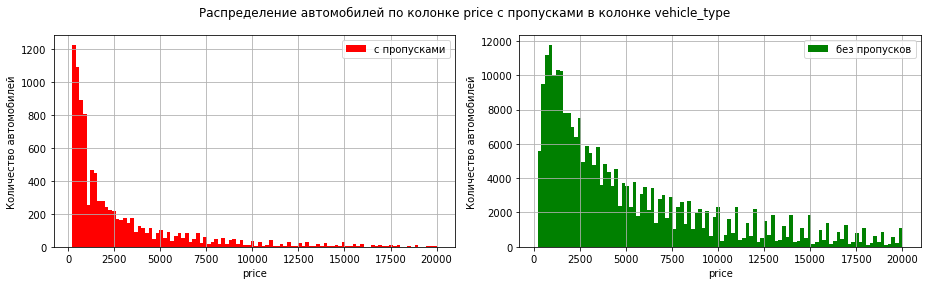

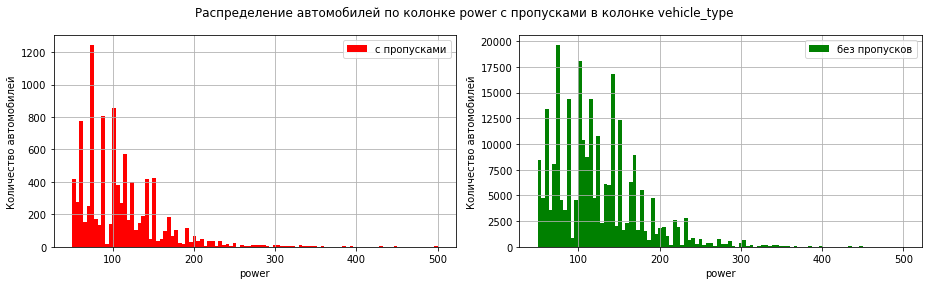

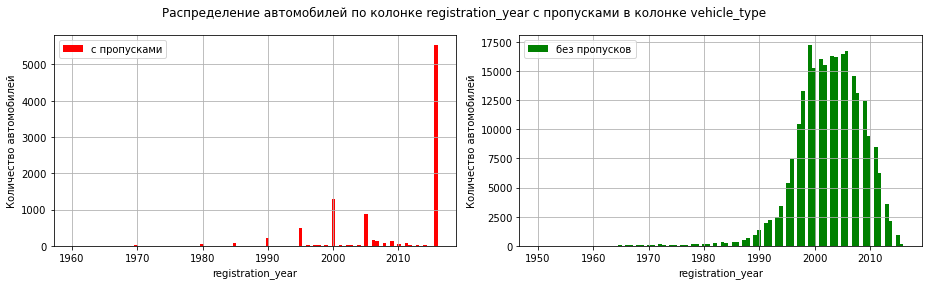

In [92]:
show_hists('vehicle_type')

Большинство пропусков связано с моделями после 2014 года.

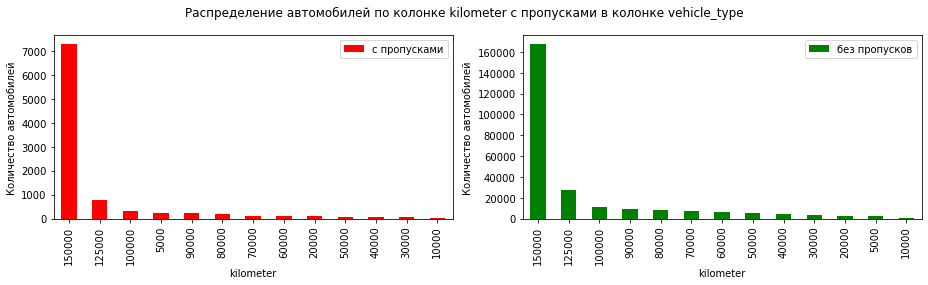

In [93]:
show_bars('vehicle_type')

Опять отметим, что пик отсутсвующей информации о типе автомобильного кузова характерен для автомобилей с максимальным пробегом.
<!-- анкет с нулевым месяцем регистрации автомобиля. -->

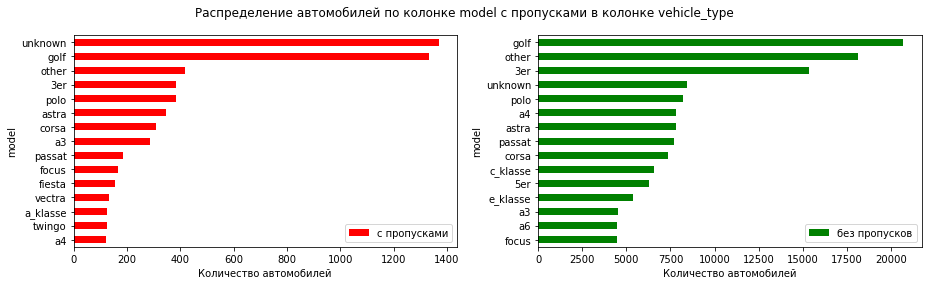

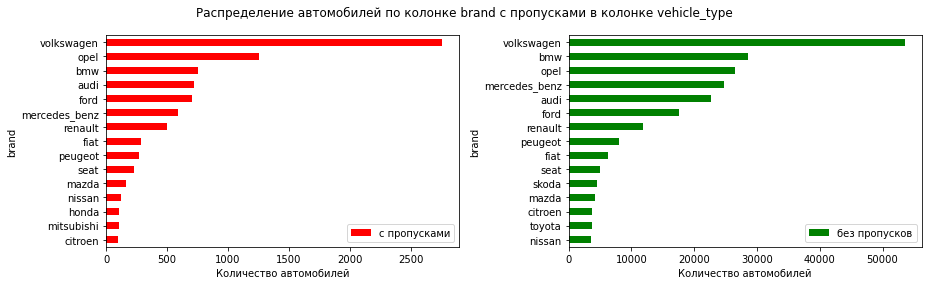

In [94]:
show_bars_from_reduced('vehicle_type')

Нет зависимости пропусков в колонке с ремонтом от марки и модели автомобиля, кроме того факта, что у машин неизвестных моделей много пропусков.

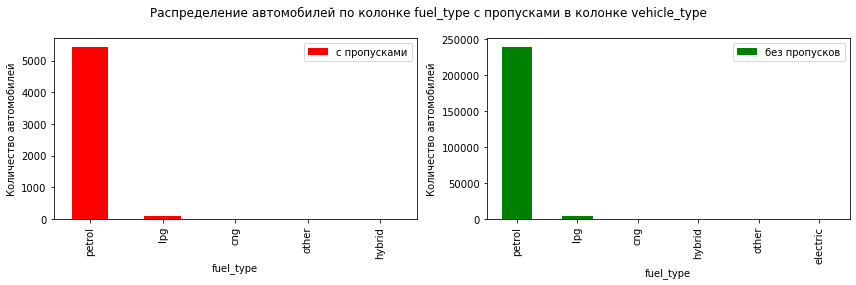

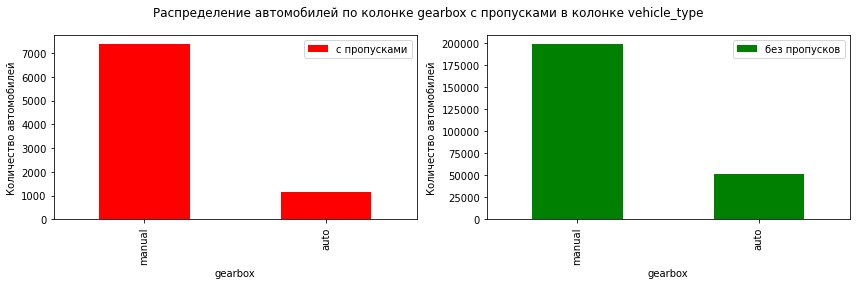

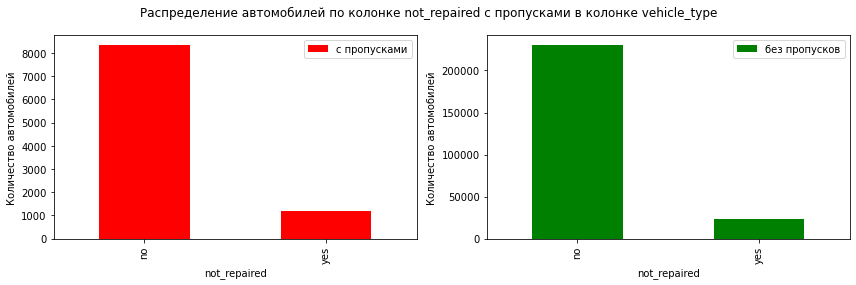

In [95]:
show_bars_from_missed('vehicle_type')

Среди данных признаков зависимость не выявлена.

Пропуски кажутся случайными, однако часто присущи более новым моделям с неизвестными моделями.
<!-- нулевого месяца регистрации. -->

Сложно представить продажу автомобиля неизвестной марки с неизвестным типом кузова. 

Такие данные стоит удалить.

In [96]:
df = df[(~df.vehicle_type.isna()) | (df.model != 'unknown')]

Продолжаем действовать согласно принципу GIGO (от *англ. garbage in — garbage out*, буквально «мусор на входе — мусор на выходе») и чистить датасет от некорректных данных. Помним, что заказчику важна точность.

Посмотрим, много ли пропусков осталось.

In [97]:
display_missing(df)

,missing,total,percent
fuel_type,"12,999","262,355",4.95%
vehicle_type,"8,177","262,355",3.12%
gearbox,"4,310","262,355",1.64%
price,0,"262,355",0.00%
registration_year,0,"262,355",0.00%
power,0,"262,355",0.00%
model,0,"262,355",0.00%
kilometer,0,"262,355",0.00%
brand,0,"262,355",0.00%
not_repaired,0,"262,355",0.00%


Посмотрим, у скольких моделей автомобилей пропущен тип кузова.

In [98]:
len(df[df.vehicle_type.isna()]['model'].unique())

216

Почти каждая модель имеет определенный тип кузова - заменим пропуски на моду кузова у конкретной модели. Для этого посмотрим, как выглядит распределение типов кузова для нескольких первых моделей.

In [99]:
df.groupby('model')['vehicle_type'].value_counts().head(15)

model  vehicle_type
100    sedan           216
       wagon            93
       coupe             2
       convertible       1
145    small            15
       sedan            12
       coupe             1
       other             1
147    sedan           318
       small            84
       coupe            23
       other             6
       wagon             2
156    wagon           243
       sedan           222
Name: vehicle_type, dtype: int64

Для контроля замены на моду возьмем 156 модель, у нее не самый частый тип кузова среди всех табличных данных - `wagon`, на который мы будем заменять пропуски в этой модели.

In [100]:
indexes = df[(df.vehicle_type.isna()) & (df.model == '156')]
indexes.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
19124,500,NaN,2000,manual,150,156,150000,NaN,alfa_romeo,no
22705,300,NaN,2000,manual,120,156,150000,petrol,alfa_romeo,no
25027,290,NaN,2016,manual,155,156,150000,NaN,alfa_romeo,no
81348,350,NaN,2016,manual,190,156,150000,petrol,alfa_romeo,no
89373,799,NaN,2005,manual,146,156,150000,NaN,alfa_romeo,no


Тип кузова отсутсвует.

Теперь заменим во всей таблице пропуски на самый встречаемый тип кузова для каждой модели. 

*Хотелось бы иметь возможность использовать `.mode()` для замены, но для типа данных `seriesgroupby` данная опция не поддерживается.* 


In [101]:
def missed_data_to_mode_by_model(column):
    df[column] = df.groupby('model')[column].transform(lambda x : x.fillna(value=x.value_counts().index[0]))

<!-- # df['vehicle_type'] = df.groupby('model')['vehicle_type'].transform(lambda x : x.fillna(value=x.value_counts().index[0])) -->


In [102]:
missed_data_to_mode_by_model('vehicle_type')

Проверяем, как прошла замена для 156 модели.

In [103]:
df.loc[indexes.index].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
19124,500,wagon,2000,manual,150,156,150000,NaN,alfa_romeo,no
22705,300,wagon,2000,manual,120,156,150000,petrol,alfa_romeo,no
25027,290,wagon,2016,manual,155,156,150000,NaN,alfa_romeo,no
81348,350,wagon,2016,manual,190,156,150000,petrol,alfa_romeo,no
89373,799,wagon,2005,manual,146,156,150000,NaN,alfa_romeo,no


In [104]:
del indexes  # удаляем лишние переменные

Контролируем график распределения.

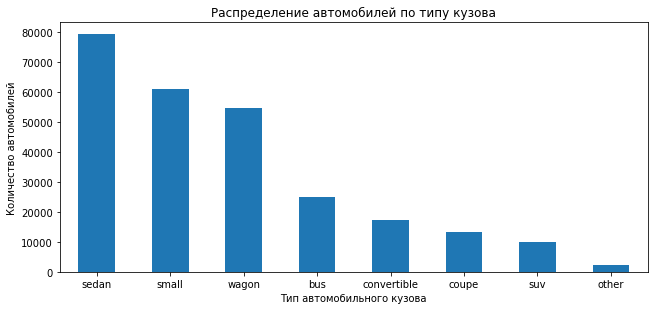

In [105]:
df['vehicle_type'].value_counts().plot(kind='bar', figsize=(9, 4), rot=0)
plt.tight_layout()

plt.xlabel('Тип автомобильного кузова')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по типу кузова')
plt.show()

Распределение данных выглядит реалистично.

Контролируем пропуски.

In [106]:
display_missing(df)

,missing,total,percent
fuel_type,"12,999","262,355",4.95%
gearbox,"4,310","262,355",1.64%
price,0,"262,355",0.00%
vehicle_type,0,"262,355",0.00%
registration_year,0,"262,355",0.00%
power,0,"262,355",0.00%
model,0,"262,355",0.00%
kilometer,0,"262,355",0.00%
brand,0,"262,355",0.00%
not_repaired,0,"262,355",0.00%


Пропуски остались только у типа топлива и коробки передач.

#### `gearbox` — тип коробки передач

Проверим пропуски на случайность для данного признака.

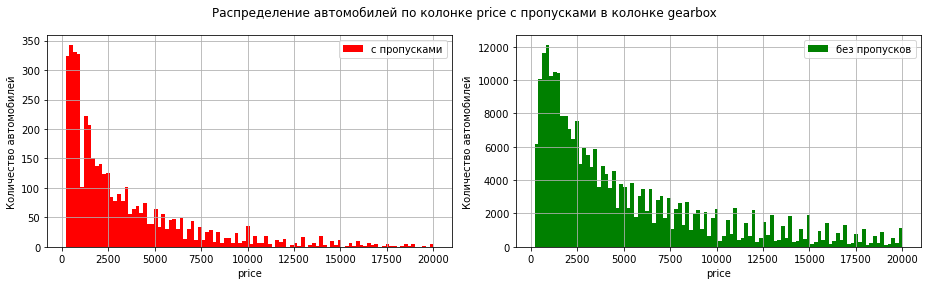

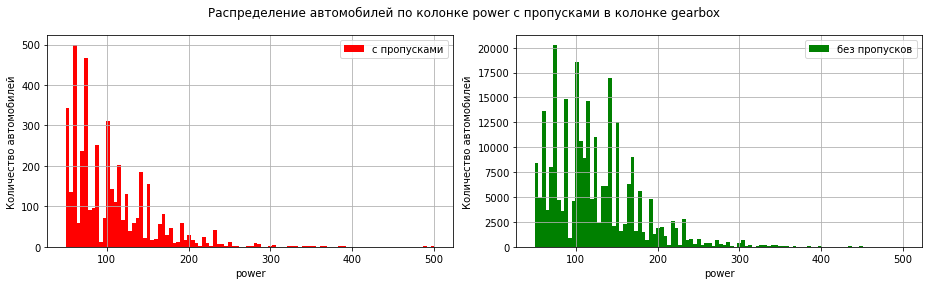

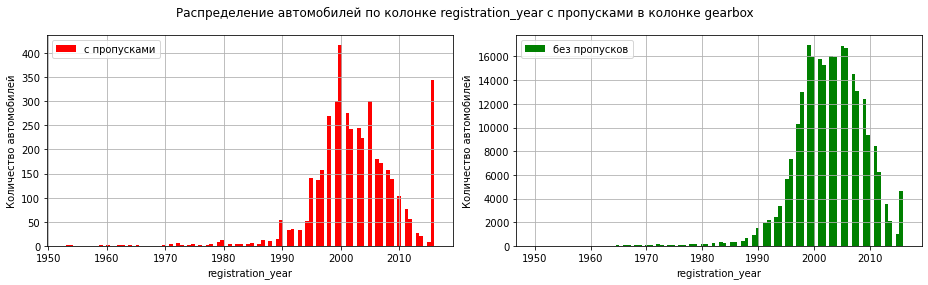

In [107]:
show_hists('gearbox')

Владельцы машин моложе 2014 года поленились указать тип коробки передач.

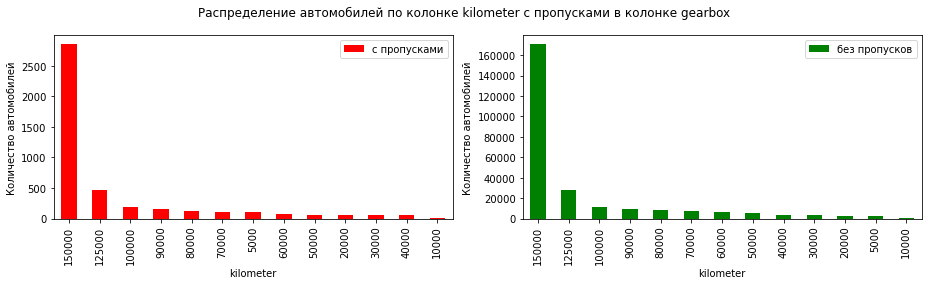

In [108]:
show_bars('gearbox')

У владельцев автомобилей с максимальным пробегом больше всего пропусков.
<!-- , зарегистрированного нулевым месяцем,  -->

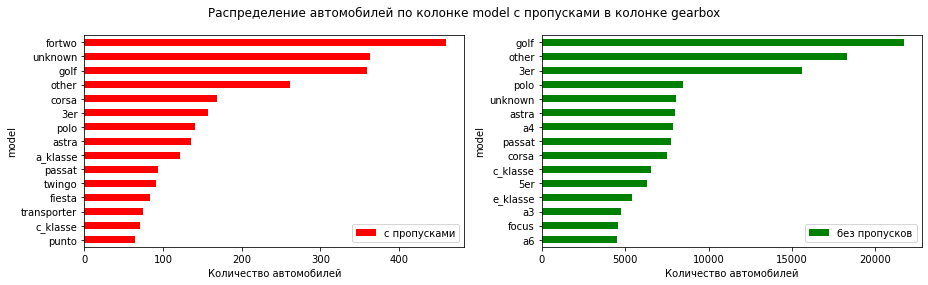

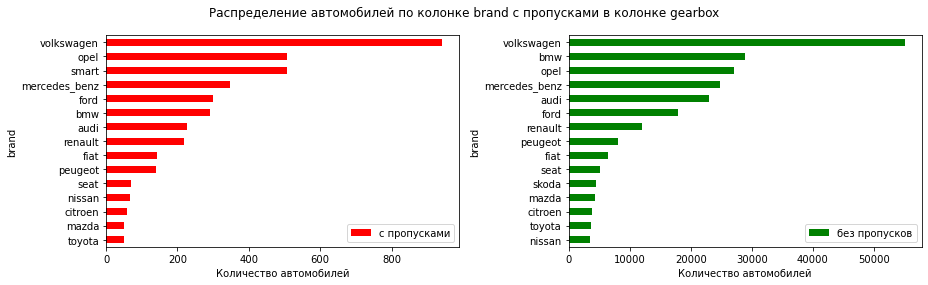

In [109]:
show_bars_from_reduced('gearbox')

Распределение реалистичное, обратим дополнительное внимание на большое количество автомобилей неизвестной марки с пропусками.

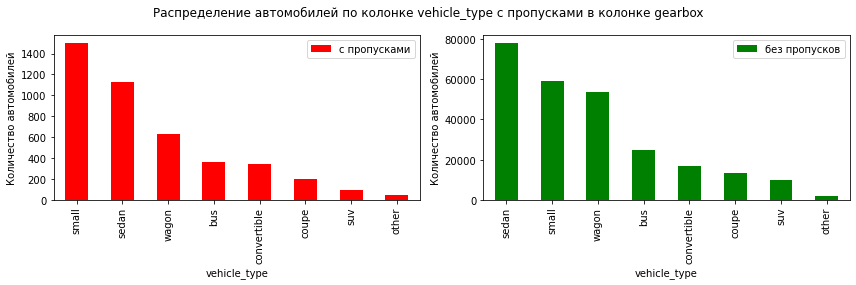

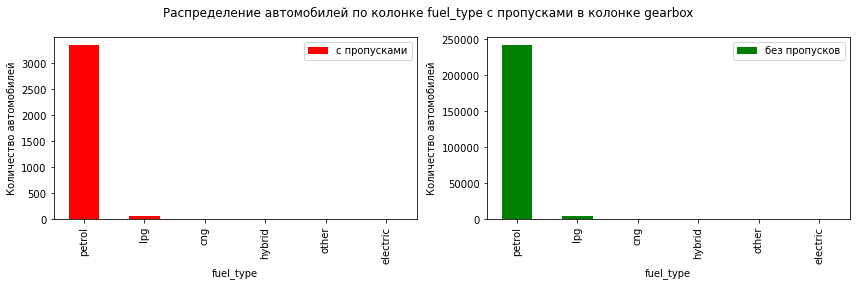

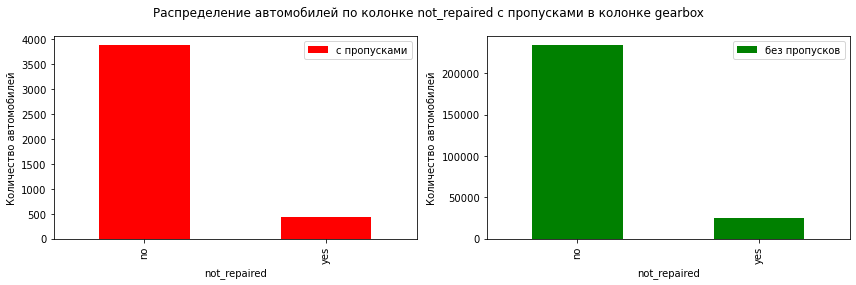

In [110]:
show_bars_from_missed('gearbox')

У автомобилей с типом кузова `small` больше всего пропусков в типе коробки передач.

Пропуски кажутся случайными, однако часто присущи более новым моделям с неизвестными моделями.
<!-- нулевого месяца регистрации. -->

Кто бы хотел купить автомобиль неизвестной марки неизвестной коробки передач? Нам сложно представить такого человека. Удалим эти данные.

In [111]:
df = df[(~df.gearbox.isna()) | (df.model != 'unknown')]

Для остальных автомобилей не будем удалять данные с пропусками, а воспользуемся той же тактикой, что и в пропусках у типа автомобильного кузова.

Посмотрим, у скольких моделей автомобилей пропущен тип коробки передач.

In [112]:
len(df[df.gearbox.isna()]['model'].unique())

196

Заменим пропуски на моду типа коробки передач у конкретной модели. Для этого посмотрим, как выглядит распределение типов коробки передач для нескольких моделей.

In [113]:
df.groupby('model')['gearbox'].value_counts().tail(15)

model     gearbox
x_trail   auto         17
x_type    manual       70
          auto         66
xc_reihe  auto        147
          manual       60
yaris     manual      756
          auto         77
yeti      manual      128
          auto         29
ypsilon   manual      131
          auto         11
z_reihe   manual      563
          auto         74
zafira    manual     1965
          auto        243
Name: gearbox, dtype: int64

Для контроля замены на моду возьмем модель `xc_reihe`, у нее не самый частый тип коробки передач среди всех табличных данных - `auto`, на который мы будем заменять пропуски в этой модели.

In [114]:
indexes = df[(df.gearbox.isna()) & (df.model == 'xc_reihe')]
indexes

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
118664,4200,suv,2004,NaN,163,xc_reihe,150000,NaN,volvo,no
247650,6650,wagon,2005,NaN,163,xc_reihe,150000,petrol,volvo,no
277116,9999,suv,2006,NaN,185,xc_reihe,150000,petrol,volvo,no


Тип коробки передач отсутсвует.

Теперь заменим во всей таблице пропуски на самый встречаемый тип коробки передач для каждой модели.

<!-- df['gearbox'] = df.groupby('model')['gearbox'].transform(lambda x : x.fillna(value=x.value_counts().index[0])) -->

In [115]:
missed_data_to_mode_by_model('gearbox')

Проверяем, как прошла замена для модели `xc_reihe`.

In [116]:
df.loc[indexes.index].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
118664,4200,suv,2004,auto,163,xc_reihe,150000,NaN,volvo,no
247650,6650,wagon,2005,auto,163,xc_reihe,150000,petrol,volvo,no
277116,9999,suv,2006,auto,185,xc_reihe,150000,petrol,volvo,no


In [117]:
del indexes  # удаляем лишние переменные

Контролируем график распределения.

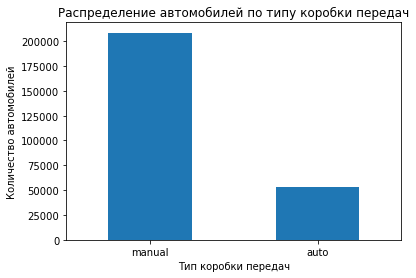

In [118]:
df['gearbox'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Тип коробки передач')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по типу коробки передач')
plt.show()

Распределение данных выглядит реалистично.

Контролируем пропуски.

In [119]:
display_missing(df)

,missing,total,percent
fuel_type,"12,859","261,992",4.91%
price,0,"261,992",0.00%
vehicle_type,0,"261,992",0.00%
registration_year,0,"261,992",0.00%
gearbox,0,"261,992",0.00%
power,0,"261,992",0.00%
model,0,"261,992",0.00%
kilometer,0,"261,992",0.00%
brand,0,"261,992",0.00%
not_repaired,0,"261,992",0.00%


Пропуски остались только у типа топлива.

#### `fuel_type` — тип топлива

Проверим пропуски на случайность для данного признака.

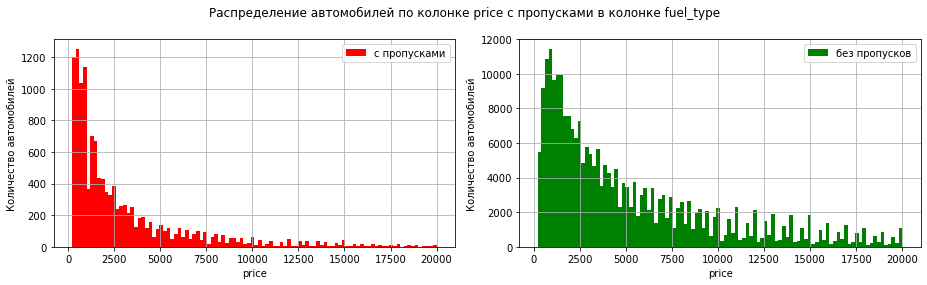

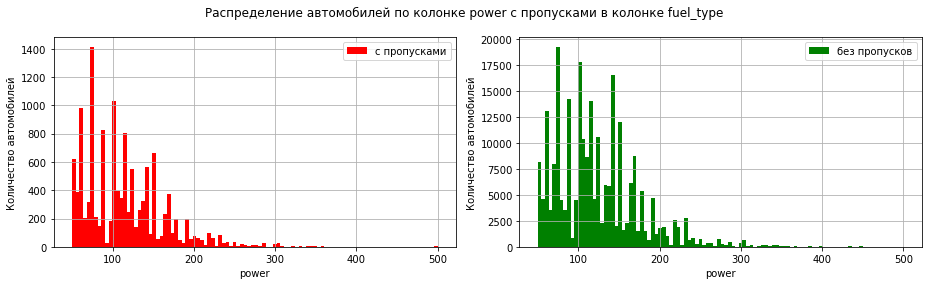

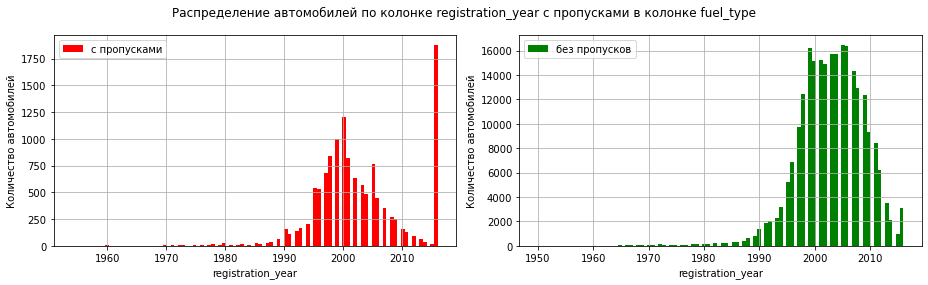

In [120]:
show_hists('fuel_type')

Наблюдаем пик пропусков для автомобилей последних лет.

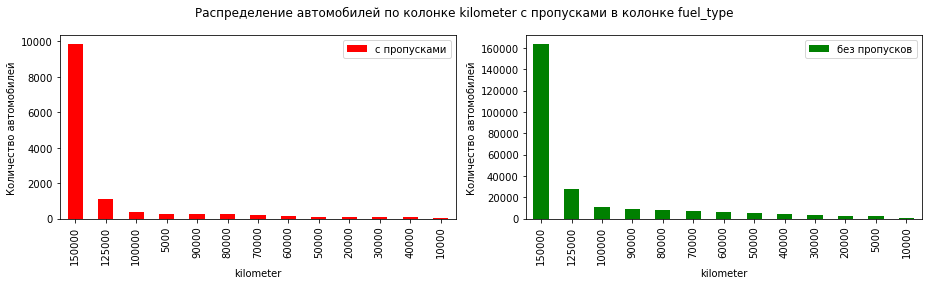

In [121]:
show_bars('fuel_type')

Распределение реалистичное: больше автомобилей в данной категории - больше пропусков.

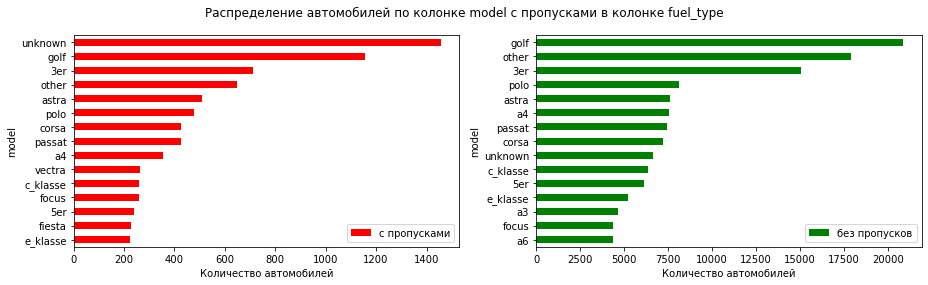

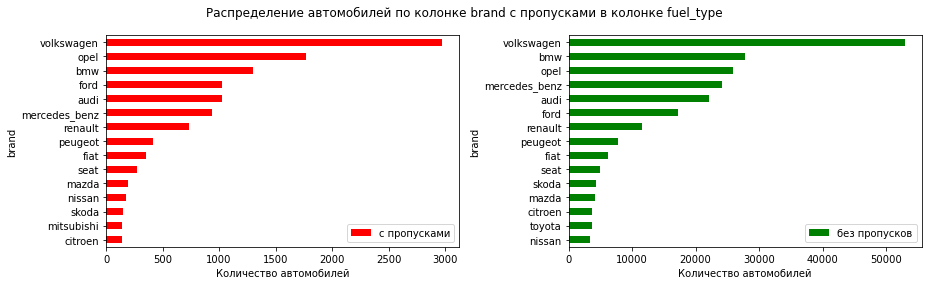

In [122]:
show_bars_from_reduced('fuel_type')

Распределение реалистичное, обратим дополнительное внимание на большое количество автомобилей неизвестной марки с пропусками.

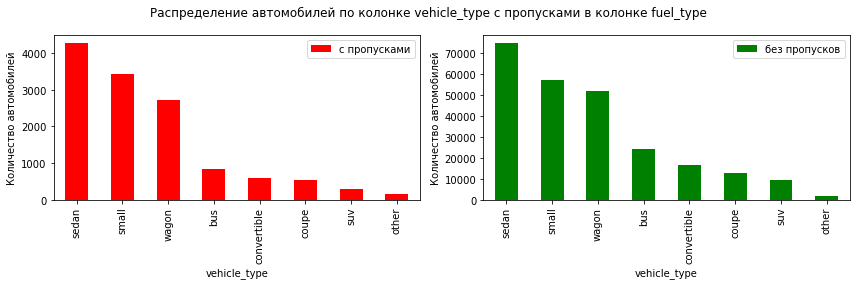

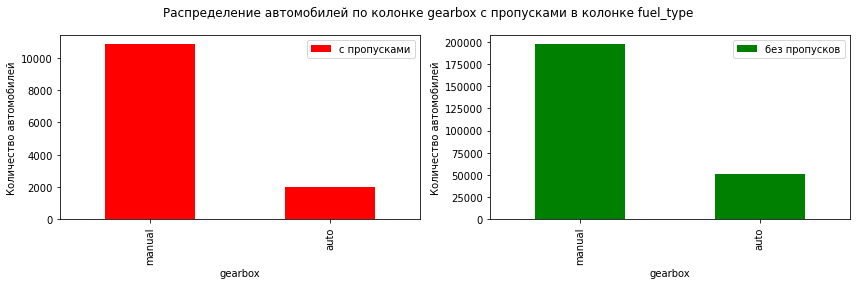

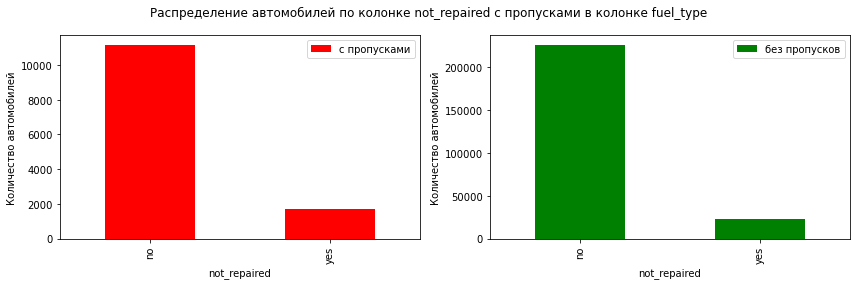

In [123]:
show_bars_from_missed('fuel_type')

Пропуски кажутся случайными, однако часто присущи более новым моделям с неизвестными моделями.

Продаем ли мы неизвестную модель автомобиля, которая ездит на неизвестном топливе? Данные автомобили решаем удалить.

In [124]:
df = df[(~df.fuel_type.isna()) | (df.model != 'unknown')]

Для остальных автомобилей не будем удалять данные с пропусками, а воспользуемся той же тактикой, что и в пропусках у типа автомобильного кузова.

Посмотрим, у скольких моделей автомобилей пропущен тип топлива.

In [125]:
len(df[df.fuel_type.isna()]['model'].unique())

226

Моделей достаточно много. Есть ли среди них те, для кого бензин не является преобладающим типом топлива?

In [126]:
fuel_list = []
for name, data in df.groupby('model'):
    fuel_list.append(data['fuel_type'].value_counts().index[0])
set(fuel_list)

{'petrol'}

In [127]:
del fuel_list

Для любой модели из выбранных бензин является преобладающим типом топлива. Заменим все пропуски в таблице на него.

In [128]:
df['fuel_type'] = df['fuel_type'].fillna('petrol')

Контролируем график распределения.

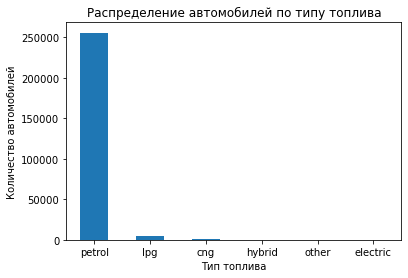

In [129]:
df['fuel_type'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Тип топлива')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по типу топлива')
plt.show()

Распределение данных выглядит реалистично.

Контролируем пропуски.

In [130]:
display_missing(df)

,missing,total,percent
price,0,"260,536",0.00%
vehicle_type,0,"260,536",0.00%
registration_year,0,"260,536",0.00%
gearbox,0,"260,536",0.00%
power,0,"260,536",0.00%
model,0,"260,536",0.00%
kilometer,0,"260,536",0.00%
fuel_type,0,"260,536",0.00%
brand,0,"260,536",0.00%
not_repaired,0,"260,536",0.00%


Пропусков в данных не осталось.

Преследуя цель создать удобное, быстрое и точное приложение для предсказания цены подержанного автомобиля мы значительно сократили таблицу с данными, избавившись от большинства неточностей и некорректных данных. В нашем распоряжении всё еще более 250 тысяч анкет.

### Проверка на мультиколлинеарность

Оценим корреляцию между числовыми признаками.

In [131]:
df.corr()

,price,registration_year,power,kilometer
price,1.000000,0.499480,0.498283,-0.393498
registration_year,0.499480,1.000000,0.096617,-0.327857
power,0.498283,0.096617,1.000000,0.112075
kilometer,-0.393498,-0.327857,0.112075,1.000000


Корреляция целевого признака с остальными ниже |0.5|. Мультиколлинеарных признаков не обнаружено.

Приступим к обучению моделей.

## Обучение моделей

### Важное отсупление
**В рамках данной работы сразу сделаем важное отступление. Модели считаются достаточно медленно, поэтому в каждой модели были перебраны разные гиперпараметры, которые впоследствии в коде были сокращены для увеличения скорости отработки тетради.**

Разделим данные на признаки и целевой признак.

In [132]:
# признаки
features = df.drop('price', axis=1)
# целевой признак
target = df['price']

Создадим переменную для значения `random_state`.

In [133]:
state = 12345

Разобъем данные на тренировочную, валидационную и тестовую выборки в пропорциях 3:1:1. Для начала отделим 20% данных под тестовую выборку `..._test`.

In [134]:
features_df, features_test, target_df, target_test = train_test_split(
    features, 
    target, 
    test_size=0.2,
    random_state=state,
    shuffle=True
)

Для некоторых моделей нам понадобится валидационная выборка, для некоторых будем использовать кросс-валидацию.

Выделим валидационную выборку.

И теперь отделим от выборок `..._df` 25% под валидационную.

In [135]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_df,
    target_df,
    test_size=0.25,
    random_state=state,
    shuffle=True
)

Посмотрим на размеры выборок.

In [136]:
features_train.shape, features_valid.shape, features_test.shape

((156321, 9), (52107, 9), (52108, 9))

Пропорция 3:1:1 соблюдена.


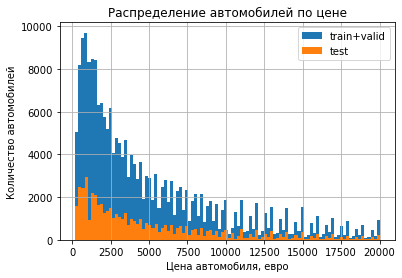

In [137]:
target_df.hist(bins=100, label='train+valid')
target_test.hist(bins=100, label='test')

plt.xlabel('Цена автомобиля, евро')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по цене')
plt.legend()
plt.show()

Распределение цены в выборках адекватное.

Чтобы приступить к обучению моделей, нужно провести кодирование категориальных и масштабирование численных признаков. 

In [138]:
del df

### Кодирование категориальных и масштабирование численных признаков

Посмотрим ещё раз на информацию о признаках.


In [139]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260536 entries, 1 to 326825
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       260536 non-null  object
 1   registration_year  260536 non-null  int64 
 2   gearbox            260536 non-null  object
 3   power              260536 non-null  int64 
 4   model              260536 non-null  object
 5   kilometer          260536 non-null  int64 
 6   fuel_type          260536 non-null  object
 7   brand              260536 non-null  object
 8   not_repaired       260536 non-null  object
dtypes: int64(3), object(6)
memory usage: 19.9+ MB


- В колонках `registration_year`, `power`, `kilometer` содержится числовая информация. 

<!-- (`not_repaired` и `gearbox_is_auto` содержит, конечно, категориальную информацию, выраженную в числовом виде) `not_repaired` и `gearbox_is_auto`  -->

- В колонках `vehicle_type`, `brand`, `model`, `fuel_type`, `not_repaired` и `gearbox_is_auto` содержится категориальная информация.

Создадим списки численных и категориальных признаков для разных кодировщиков.

In [140]:
numeric_to_scaler = ['registration_year', 'power', 'kilometer']
categorical_to_ohe = ['vehicle_type', 'brand', 'fuel_type', 'not_repaired', 'gearbox']
categorical_to_target = ['model']

Масштабируем численные данные, хранящиеся в выборках, используя стандартизацию.

Создадим объект структуры `RobustScaler`.


In [141]:
scaler = RobustScaler()

Далее мы используем его в `Pipeline`.

Для категориальных признаков используем кодирование.

И тут возникает проблема. 

Мы можем использовать OHE - наиболее простой, понятный и подходящий для любых моделей кодировщик, однако в случае с моделью автомобиля такой вариант приведет к значительному раздуванию признаков.

Так что появилась идея использовать для модели `TargetEncoder`. Далее приведем объяснение по работе данного кодировщика от начинающего специалиста Data Science Сергея Трощиева: 

_"<...> идея простая, например, у тебя есть категориальная фича: бренд авто. Ты группируешь свой ОБУЧАЮЩИЙ датафрейм по бренду, выделяешь столбец цена, а потом применяешь аггрегурующую функцию, например,_

`mean.df.groupby('brand')['price'].mean()`

*У тебя получится сериес из порядка 40 строк. А индексом будут бренды авто. Потом берешь и обучающий, и тестовый датафрейм, и вместо категории "бренд" вписываешь среднюю цену этого бренда из обучающей выборки*

*важно, что нельзя эту штуку обучать на всей выборке, включая тестовую, потому что у тебя будет утечка целевого признака. Поэтому средние вычисляем только на обучающей, а потом их уже раскатываем на весь датасет <...>" (из личной переписки)*

      

Опыт новый, но будем пробовать.

Создадим объект кодировщика.

In [142]:
target_encoder = ce.TargetEncoder(
    min_samples_leaf=3,
#     cols=[categorical_to_target]
)

Далее создадим объет класса `ColumnTransformer`, чтобы объединить различные методы обработки признаков.

In [143]:
ct =  make_column_transformer(
    (scaler, numeric_to_scaler),
    (OneHotEncoder(), categorical_to_ohe),
    (target_encoder, categorical_to_target)
)
ct

ColumnTransformer(transformers=[('robustscaler', RobustScaler(),
                                 ['registration_year', 'power', 'kilometer']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['vehicle_type', 'brand', 'fuel_type',
                                  'not_repaired', 'gearbox']),
                                ('targetencoder',
                                 TargetEncoder(min_samples_leaf=3),
                                 ['model'])])

Итак, мы проверили данные на мультиколлинеарность и прикинули необходимые методы обработки каждого признака.

В рамках данной работы нам бы хотелось обучить несколько моделей и сравнить их между собой по точности предсказаний и скорости работы.
Выберем следующие модели для исследования:
1. Модели линейной регрессии
2. Модель случайного леса
3. Модель градиентного бустинга в реализации библиотеки LightGBM

### Оценка адекватности моделей

Для оценки адекватности модели будем использовать `DummyRegressor`, предсказывающий среднее значение целевого признака обучающей выборки.

In [144]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(features_train, target_train)
dummy_regr_predicted = dummy_regr.predict(features_valid)

Рассчитаем RMSE константной модели.

In [145]:
rmse_dummy = mean_squared_error(target_valid,
                   dummy_regr_predicted, 
                   squared=False
                  )
print(f'RMSE для константной модели {rmse_dummy:.1f} евро')

RMSE для константной модели 4640.7 евро


Использовать время обучения для константной модели в качестве какого-то параметра не совсем информативно и интересно, учтем только метрику качества.

Создадим таблицу для учета скорости и качества работы разных моделей.

In [146]:
results = pd.DataFrame(columns=['valid_RMSE', 'train_time', 'predict_time'])

Заполним её данными для константной модели. Сразу для наглядности округлим результаты до целых значений в евро.

In [147]:
results.loc['dummy', 'valid_RMSE'] = round(rmse_dummy)

In [148]:
results

,valid_RMSE,train_time,predict_time
dummy,4641,NaN,NaN


Превратим метрику RMSE в `scorer`, который можно использовать как параметр функции `cross_val_score`.


In [149]:
rmse = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

### Модель линейной регрессии

Возьмем для исследования пару моделей линейной регрессии:
- Lasso
- Ridge

#### Lasso

Построим пайплайн для модели линейной регрессии Lasso.

In [150]:
pipe_lasso = Pipeline([
    ('column_transformer', ct),
    ('model', Lasso(random_state=state, max_iter=10))

])

params_lasso = [
    {
        'model': [Lasso(random_state=state)],
#         'model__alpha': np.logspace(-3, 1, 3), параметры при подборе
        'model__alpha': [0.1], # параметры после подбора
    },
]

cv = KFold(n_splits=3, shuffle=True, random_state=state)

In [151]:
grid_lasso = GridSearchCV(pipe_lasso, param_grid=params_lasso, cv=cv, n_jobs=-1, scoring=rmse, verbose=2)

In [152]:
grid_lasso.fit(features_train, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('robustscaler',
                                                                         RobustScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['vehicle_type',
                                                                          'brand',
                                                                          'fuel_type',
                                                                          'not_repaired',
                                                                          'gearbox']),
                                                                        ('targetencoder',
                                                                         TargetEncoder(min_samples_leaf=3),
                                                                         ['model'])])),
                                       ('model',
                                        Lasso(max_iter=10,
                                              random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [Lasso(alpha=0.1, random_state=12345)],
                          'model__alpha': [0.1]}],
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=2)

In [153]:
lasso_rmse = -grid_lasso.best_score_
print('Best Params:', grid_lasso.best_params_)
print()
print('Best RMSE Score:', lasso_rmse)

Best Params: {'model': Lasso(alpha=0.1, random_state=12345), 'model__alpha': 0.1}

Best RMSE Score: 2745.8234830409906


Кросс-валидацией нашли лучшую модель, сохраним ее.

In [154]:
lasso_model = grid_lasso.best_estimator_

Теперь узнаем время обучения и время предсказания модели.

Время обучения.

In [155]:
start_time = time.time()
lasso_model.fit(features_train, target_train)

fit_time_lasso = time.time() - start_time

In [156]:
print(f'Время обучения Lasso: {fit_time_lasso:0.2f}')

Время обучения Lasso: 26.62


Время предсказания.

In [157]:
start_time = time.time()
lasso_predicts = lasso_model.predict(features_valid)
predict_time_lasso = time.time() - start_time

In [158]:
print(f'Время предсказания Lasso: {predict_time_lasso:.2f}')

Время предсказания Lasso: 0.15


Рассчитаем метрику качества.

In [159]:
rmse_lasso = mean_squared_error(target_valid,
                   lasso_predicts, 
                   squared=False
                  )
print(f'RMSE для модели Lasso {rmse_lasso:.1f} евро')

RMSE для модели Lasso 2733.0 евро


Внесем данные в таблицу результатов.

In [160]:
results.loc['lasso', 'valid_RMSE'] = round(rmse_lasso)
results.loc['lasso', 'train_time'] = round(fit_time_lasso, 2)
results.loc['lasso', 'predict_time'] = round(predict_time_lasso, 2)

In [161]:
results

,valid_RMSE,train_time,predict_time
dummy,4641,NaN,NaN
lasso,2733,26.62,0.15


#### Ridge

Построим пайплайн для модели линейной регрессии Ridge.

In [162]:
pipe_ridge = Pipeline([
    ('column_transformer', ct),
    ('model', Ridge(random_state=state, max_iter=1000))

])

params_ridge = [
    {
        'model': [Ridge(random_state=state)],
        'model__alpha': [0.1, 0.5, 1, 5, 10, 20, 40], # параметры при подборе
#         'model__alpha': 0.1, # параметры после подбора
    },
]

In [163]:
grid_ridge = GridSearchCV(pipe_ridge, param_grid=params_ridge, cv=cv, n_jobs=-1, scoring=rmse, verbose=1)

In [164]:
grid_ridge.fit(features_train, target_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('robustscaler',
                                                                         RobustScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['vehicle_type',
                                                                          'brand',
                                                                          'fuel_type',
                                                                          'not_repaired',
                                                                          'gearbox']),
                                                                        ('targetencoder',
                                                                         TargetEncoder(min_samples_leaf=3),
                                                                         ['model'])])),
                                       ('model',
                                        Ridge(max_iter=1000,
                                              random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [Ridge(alpha=40, random_state=12345)],
                          'model__alpha': [0.1, 0.5, 1, 5, 10, 20, 40]}],
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=1)

In [165]:
ridge_rmse = -grid_ridge.best_score_
print('Best Params:', grid_ridge.best_params_)
print()
print('Best RMSE Score:', ridge_rmse)

Best Params: {'model': Ridge(alpha=40, random_state=12345), 'model__alpha': 40}

Best RMSE Score: 3950.1249235146047


Кросс-валидацией нашли лучшую модель, сохраним ее.

In [166]:
ridge_model = grid_ridge.best_estimator_

Теперь узнаем время обучения и время предсказания модели.

Время обучения.

In [167]:
start_time = time.time()
ridge_model.fit(features_train, target_train)

fit_time_ridge = time.time() - start_time

In [168]:
print(f'Время обучения Ridge: {fit_time_ridge:0.2f}')

Время обучения Ridge: 0.68


Время предсказания.

In [169]:
start_time = time.time()
ridge_predicts = ridge_model.predict(features_valid)
predict_time_ridge = time.time() - start_time

In [170]:
print(f'Время предсказания Ridge: {predict_time_ridge:.2f}')

Время предсказания Ridge: 0.17


Рассчитаем метрику качества.

In [171]:
rmse_ridge = mean_squared_error(target_valid,
                   ridge_predicts, 
                   squared=False
                  )
print(f'RMSE для модели Ridge {rmse_ridge:.1f} евро')

RMSE для модели Ridge 3960.8 евро


Внесем данные в таблицу результатов.

In [172]:
results.loc['ridge', 'valid_RMSE'] = round(rmse_ridge)
results.loc['ridge', 'train_time'] = round(fit_time_ridge, 2)
results.loc['ridge', 'predict_time'] = round(predict_time_ridge, 2)

In [173]:
results

,valid_RMSE,train_time,predict_time
dummy,4641,NaN,NaN
lasso,2733,26.62,0.15
ridge,3961,0.68,0.17


### Модель случайного леса

Построим пайплайн для модели случайного леса.

In [174]:
pipe_forest = Pipeline([
    ('column_transformer', ct),
    ('model', RandomForestRegressor(random_state=state, n_jobs=-1))

])

params_forest = [
    {
        'model': [RandomForestRegressor(random_state=state)],
        # 'model__n_estimators': list(range(1, 100, 20)), # параметры при подборе
        'model__n_estimators': [61], # параметры после подбора

        # 'model__max_depth': list(range(2, 10, 2)), # параметры при подборе
        'model__max_depth': [8], # параметры после подбора
    },
]

In [175]:
grid_forest = GridSearchCV(pipe_forest, param_grid=params_forest, cv=cv, n_jobs=-1, scoring=rmse, verbose=3)

In [176]:
grid_forest.fit(features_train, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('robustscaler',
                                                                         RobustScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['vehicle_type',
                                                                          'brand',
                                                                          'fuel_type',
                                                                          'not_repaired',
                                                                          'gearbox']),
                                                                        ('targetencoder',
                                                                         TargetEncoder(min_samples_leaf=3),
                                                                         ['model'])])),
                                       ('model',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(max_depth=8,
                                                          n_estimators=61,
                                                          random_state=12345)],
                          'model__max_depth': [8],
                          'model__n_estimators': [61]}],
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=3)

In [177]:
forest_rmse = -grid_forest.best_score_
print('Best Params:', grid_forest.best_params_)
print()
print('Best RMSE Score:', forest_rmse)

Best Params: {'model': RandomForestRegressor(max_depth=8, n_estimators=61, random_state=12345), 'model__max_depth': 8, 'model__n_estimators': 61}

Best RMSE Score: 1958.138451604491


Кросс-валидацией нашли лучшую модель, сохраним ее.

In [178]:
forest_model = grid_forest.best_estimator_

Теперь узнаем время обучения и время предсказания модели.

Время обучения.

In [179]:
start_time = time.time()
forest_model.fit(features_train, target_train)

fit_time_forest = time.time() - start_time

In [180]:
print(f'Время обучения RandomForest: {fit_time_forest:0.2f}')

Время обучения RandomForest: 69.57


Время предсказания.

In [181]:
start_time = time.time()
forest_predicts = forest_model.predict(features_valid)
predict_time_forest = time.time() - start_time

In [182]:
print(f'Время предсказания RandomForest: {predict_time_forest:.2f}')

Время предсказания RandomForest: 0.45


Рассчитаем метрику качества.

In [183]:
rmse_forest = mean_squared_error(target_valid,
                   forest_predicts, 
                   squared=False
                  )
print(f'RMSE для модели RandomForest {rmse_forest:.1f} евро')

RMSE для модели RandomForest 1957.8 евро


Внесем данные в таблицу результатов.

In [184]:
results.loc['random_forest', 'valid_RMSE'] = round(rmse_forest)
results.loc['random_forest', 'train_time'] = round(fit_time_forest, 2)
results.loc['random_forest', 'predict_time'] = round(predict_time_forest, 2)

In [185]:
results

,valid_RMSE,train_time,predict_time
dummy,4641,NaN,NaN
lasso,2733,26.62,0.15
ridge,3961,0.68,0.17
random_forest,1958,69.57,0.45


### Модель градиентного бустинга библиотеки LightGBM

Так же для данной модели попробуем построить пайплайн.

In [186]:
pipe_light = Pipeline([
    ('column_transformer', ct),
    ('model', LGBMRegressor(random_state=state))

])

params_light = [
    {
        'model': [LGBMRegressor(random_state=state)],
#         'model__n_estimators': list(range(1, 300, 20)), # параметры при подборе
        'model__n_estimators': [280], # параметры после подбора

#         'model__max_depth': list(range(2, 20, 2)), # параметры при подборе
        'model__max_depth': [13], # параметры после подбора
    },
]

In [187]:
grid_light = GridSearchCV(pipe_light, param_grid=params_light, cv=cv, n_jobs=-1, scoring=rmse, verbose=1)

In [188]:
grid_light.fit(features_train, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('robustscaler',
                                                                         RobustScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['vehicle_type',
                                                                          'brand',
                                                                          'fuel_type',
                                                                          'not_repaired',
                                                                          'gearbox']),
                                                                        ('targetencoder',
                                                                         TargetEncoder(min_samples_leaf=3),
                                                                         ['model'])])),
                                       ('model',
                                        LGBMRegressor(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [LGBMRegressor(max_depth=13,
                                                  n_estimators=280,
                                                  random_state=12345)],
                          'model__max_depth': [13],
                          'model__n_estimators': [280]}],
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=1)

In [189]:
light_rmse = -grid_light.best_score_
print('Best Params:', grid_light.best_params_)
print()
print('Best RMSE Score:', light_rmse)

Best Params: {'model': LGBMRegressor(max_depth=13, n_estimators=280, random_state=12345), 'model__max_depth': 13, 'model__n_estimators': 280}

Best RMSE Score: 1610.020308293876


Кросс-валидацией нашли лучшую модель, сохраним ее.

In [190]:
light_model = grid_light.best_estimator_

Теперь узнаем время обучения и время предсказания модели.

Время обучения.

In [191]:
start_time = time.time()
light_model.fit(features_train, target_train)

fit_time_light = time.time() - start_time

In [192]:
print(f'Время обучения LGBMRegressor: {fit_time_light:0.2f}')

Время обучения LGBMRegressor: 2.21


Время предсказания.

In [193]:
start_time = time.time()
light_predicts = light_model.predict(features_valid)
predict_time_light = time.time() - start_time

In [194]:
print(f'Время предсказания LGBMRegressor: {predict_time_light:.2f}')

Время предсказания LGBMRegressor: 0.63


Рассчитаем метрику качества.

In [195]:
rmse_light = mean_squared_error(target_valid,
                   light_predicts, 
                   squared=False
                  )
print(f'RMSE для модели LGBMRegressor {rmse_light:.1f} евро')

RMSE для модели LGBMRegressor 1593.6 евро


Внесем данные в таблицу результатов.

In [196]:
results.loc['LGBM', 'valid_RMSE'] = round(rmse_light)
results.loc['LGBM', 'train_time'] = round(fit_time_light, 2)
results.loc['LGBM', 'predict_time'] = round(predict_time_light, 2)

In [197]:
results

,valid_RMSE,train_time,predict_time
dummy,4641,NaN,NaN
lasso,2733,26.62,0.15
ridge,3961,0.68,0.17
random_forest,1958,69.57,0.45
LGBM,1594,2.21,0.63


Обучим lgbm с внутренней обработкой категориальных признаков чтобы посмотреть, какой подход дает лучший результат.

In [198]:
cat_col = features_train.select_dtypes('object').columns.tolist()
cat_col

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [199]:
for feature in cat_col:
    features_train[feature] = pd.Series(features_train[feature], dtype="category")
    features_valid[feature] = pd.Series(features_valid[feature], dtype="category")
    features_test[feature] = pd.Series(features_test[feature], dtype="category")
    features_df[feature] = pd.Series(features_df[feature], dtype="category")
    

In [200]:
booster = lgb.LGBMModel(objective="regression", n_estimators=280, max_depth=13, random_state=state)

Теперь узнаем время обучения и время предсказания модели.

Время обучения.

In [201]:
start_time = time.time()

booster.fit(
    features_train,
    target_train,
    eval_set=[(features_valid, target_valid),], 
    eval_metric="rmse", 
    categorical_feature='auto',
    verbose=10,
    early_stopping_rounds=10
)

fit_time_light_2 = time.time() - start_time


[10]	valid_0's rmse: 2537.14	valid_0's l2: 6.43709e+06
[20]	valid_0's rmse: 1912.62	valid_0's l2: 3.65811e+06
[30]	valid_0's rmse: 1736.16	valid_0's l2: 3.01424e+06
[40]	valid_0's rmse: 1676.32	valid_0's l2: 2.81005e+06
[50]	valid_0's rmse: 1649.44	valid_0's l2: 2.72065e+06
[60]	valid_0's rmse: 1634.48	valid_0's l2: 2.67153e+06
[70]	valid_0's rmse: 1623.42	valid_0's l2: 2.6355e+06
[80]	valid_0's rmse: 1615.99	valid_0's l2: 2.61141e+06
[90]	valid_0's rmse: 1609.05	valid_0's l2: 2.58905e+06
[100]	valid_0's rmse: 1603.55	valid_0's l2: 2.57136e+06
[110]	valid_0's rmse: 1596.58	valid_0's l2: 2.54907e+06
[120]	valid_0's rmse: 1592.23	valid_0's l2: 2.5352e+06
[130]	valid_0's rmse: 1588.06	valid_0's l2: 2.52195e+06
[140]	valid_0's rmse: 1584.81	valid_0's l2: 2.51163e+06
[150]	valid_0's rmse: 1581.31	valid_0's l2: 2.50055e+06
[160]	valid_0's rmse: 1578.52	valid_0's l2: 2.49172e+06
[170]	valid_0's rmse: 1575.96	valid_0's l2: 2.48366e+06
[180]	valid_0's rmse: 1574.42	valid_0's l2: 2.47879e+06
[19

In [202]:
print(f'Время обучения LGBMRegressor со встроенной обработкой признаков: {fit_time_light_2:0.2f}')

Время обучения LGBMRegressor со встроенной обработкой признаков: 2.96


Время предсказания.

In [203]:
start_time = time.time()
light_predicts_2 = booster.predict(features_valid)
predict_time_light_2 = time.time() - start_time

In [204]:
print(f'Время предсказания LGBMRegressor со встроенной обработкой признаков: {predict_time_light_2:.2f}')

Время предсказания LGBMRegressor со встроенной обработкой признаков: 0.59


Рассчитаем метрику качества.

In [205]:
rmse_light_2 = mean_squared_error(target_valid,
                   light_predicts_2, 
                   squared=False
                  )
print(f'RMSE для модели LGBMRegressor со встроенной обработкой признаков {rmse_light_2:.1f} евро')

RMSE для модели LGBMRegressor со встроенной обработкой признаков 1561.0 евро


Видим, что метрика качества при повторении модели со встроенной обработкой признаков улучшилась только на 30 евро.

Посмотрим на важность признаков, данная возможность сразу зашита в библиотеку.

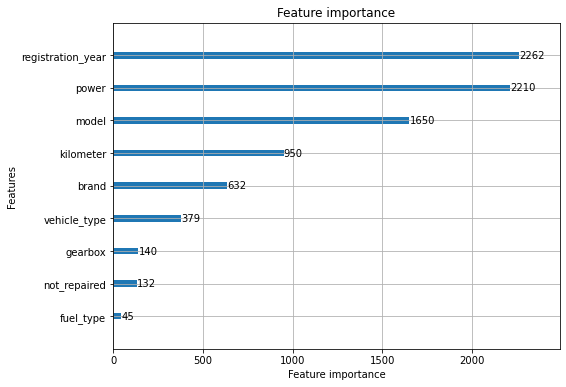

In [206]:
lgb.plot_importance(booster, figsize=(8,6))
plt.show()

На цену очень влияет год регистрации автомобиля, мощность и модель.

Так же у нас есть возможность оценить, как изменялась метрика качества в зависимости от количества итераций.

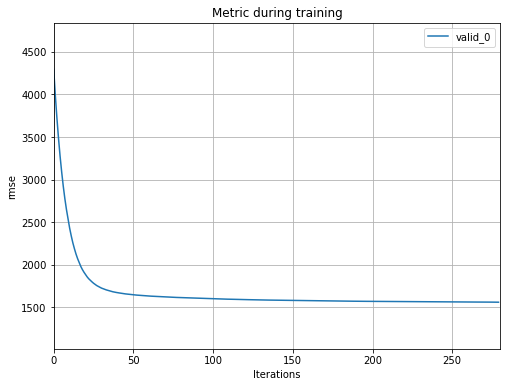

In [207]:
lgb.plot_metric(booster, metric="rmse", figsize=(8,6))
plt.show()

Уже к 50 итерациям метрика качества перестала стремительно меняться.

In [208]:
pipe_light_3 = Pipeline([
#     ('column_transformer', ct),
    ('model', booster)])

params_light_3 = [
    {
        'model': [booster],
#         'model__n_estimators': list(range(1, 300, 20)), # параметры при подборе
        'model__n_estimators': [280], # параметры после подбора

#         'model__max_depth': list(range(2, 20, 2)), # параметры при подборе
        'model__max_depth': [13], # параметры после подбора
#         'categorical_feature': categorical_index
    },
]


# fit_params = {'categorical_feature': categorical_index}

grid_light_3 = GridSearchCV(pipe_light_3, param_grid=params_light_3, cv=cv, n_jobs=-1, scoring=rmse, verbose=1)


grid_light_3.fit(features_train, target_train)

light_rmse_3 = -grid_light_3.best_score_
print('Best Params:', grid_light_3.best_params_)
print()
print('Best RMSE Score:', light_rmse_3)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Params: {'model': LGBMModel(max_depth=13, n_estimators=280, objective='regression',
          random_state=12345), 'model__max_depth': 13, 'model__n_estimators': 280}

Best RMSE Score: 1588.617880830808


Кросс-валидацией нашли лучшую модель, сохраним ее.

In [209]:
light_model_3 = grid_light_3.best_estimator_

Теперь узнаем время обучения и время предсказания модели.

Время обучения.

In [210]:
start_time = time.time()
light_model_3.fit(features_train, target_train)

fit_time_light_3 = time.time() - start_time

In [211]:
print(f'Время обучения LGBMRegressor v2: {fit_time_light_3:0.2f}')

Время обучения LGBMRegressor v2: 1.86


Время предсказания.

In [212]:
start_time = time.time()
light_predicts_3 = light_model_3.predict(features_valid)
predict_time_light_3 = time.time() - start_time

In [213]:
print(f'Время предсказания LGBMRegressor v2: {predict_time_light_3:.2f}')

Время предсказания LGBMRegressor v2: 0.56


Рассчитаем метрику качества.

In [214]:
rmse_light_3 = mean_squared_error(target_valid,
                   light_predicts_3, 
                   squared=False
                  )
print(f'RMSE для модели LGBMRegressor v2 {rmse_light_3:.1f} евро')

RMSE для модели LGBMRegressor v2 1561.0 евро


Внесем данные в таблицу результатов.

In [215]:
results.loc['LGBM_2', 'valid_RMSE'] = round(rmse_light_3)
results.loc['LGBM_2', 'train_time'] = round(fit_time_light_3, 2)
results.loc['LGBM_2', 'predict_time'] = round(predict_time_light_3, 2)

In [216]:
results

,valid_RMSE,train_time,predict_time
dummy,4641,NaN,NaN
lasso,2733,26.62,0.15
ridge,3961,0.68,0.17
random_forest,1958,69.57,0.45
LGBM,1594,2.21,0.63
LGBM_2,1561,1.86,0.56


## Анализ моделей

Мы получили итоговые результаты по скорости и качеству моделей. 

Взглянем на время обучения моделей.

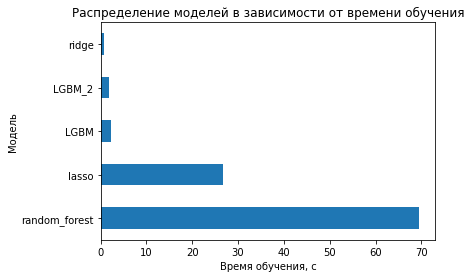

In [217]:
results.drop('dummy')['train_time'].sort_values(ascending=False).plot(kind='barh')
plt.ylabel('Модель')
plt.xlabel('Время обучения, с')
plt.title('Распределение моделей в зависимости от времени обучения')
plt.show()

- Самой быстрой моделью оказалась гребневая модель.
- Cамой долгой - модель случайного леса. 


- Модель градиентного бустинга со встроенной обработкой признаков оказалась немного быстрее в обучении.

Взглянем на время предсказания моделей.

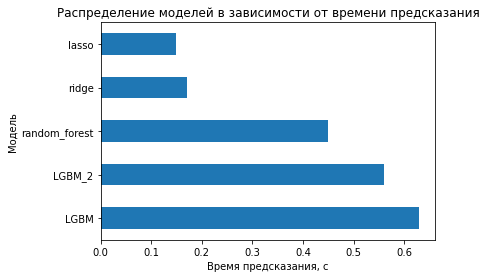

In [218]:
results.drop('dummy')['predict_time'].sort_values(ascending=False).plot(kind='barh')
plt.ylabel('Модель')
plt.xlabel('Время предсказания, с')
plt.title('Распределение моделей в зависимости от времени предсказания')
plt.show()

- Самой быстрой моделью оказалась гребневая модель.
- Cамой долгой - модель градиентного бустинга.


- Модель градиентного бустинга со встроенной обработкой признаков оказалась немного медленнее в предсказании.

Теперь взглянем на то, какое качество показали исследуемые модели.

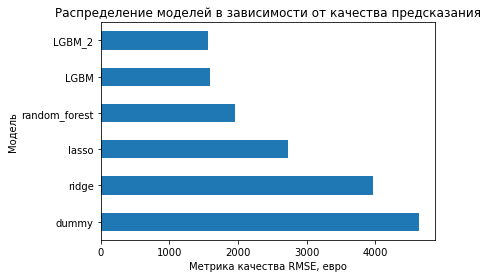

In [219]:
results['valid_RMSE'].sort_values(ascending=False).plot(kind='barh')
plt.ylabel('Модель')
plt.xlabel('Метрика качества RMSE, евро')
plt.title('Распределение моделей в зависимости от качества предсказания')
plt.show()

In [220]:
results

,valid_RMSE,train_time,predict_time
dummy,4641,NaN,NaN
lasso,2733,26.62,0.15
ridge,3961,0.68,0.17
random_forest,1958,69.57,0.45
LGBM,1594,2.21,0.63
LGBM_2,1561,1.86,0.56


- Константная модель оказалась в самом низу рейтинга со значением RMSE 4641 евро. Таким образом, любая молель предсказывает лучше константной. 

- Линейные модели показали худшие метрики качества.
- Случайный лес дольше обучается и быстрее предсказывает, но проигрывает в качестве градиентному бустингу.


- Модель градиентного бустинга со встроенной обработкой признаков оказалась немного точнее в предсказании.


- Таким образом для финального тестирования выбираем **модель градиентного бустинга со встроенной обработкой признаков**.



Обучим модель градиентного бустинга тренировочной + обучающая выборках и проверим на тестировочной.

Время финального обучения.

In [221]:
start_time = time.time()
light_model_3.fit(features_df, target_df)

fit_time_test = time.time() - start_time

print(f'Время финального обучения LGBMRegressor со встроенной обработкой признаков: {fit_time_test:0.2f}')

Время финального обучения LGBMRegressor со встроенной обработкой признаков: 2.37


Время финального предсказания.

In [222]:
start_time = time.time()
test_predicts = light_model_3.predict(features_test)
predict_time_test = time.time() - start_time

print(f'Время финального предсказания LGBMRegressor: {predict_time_test:.2f}')

Время финального предсказания LGBMRegressor: 0.51


Рассчитаем метрику качества для тестовой выборки.

In [223]:
rmse_test = mean_squared_error(target_test,
                   test_predicts, 
                   squared=False
                  )
print(f'Финальное значение RMSE для модели LGBMRegressor со встроенной обработкой признаков {rmse_test:.1f} евро')

Финальное значение RMSE для модели LGBMRegressor со встроенной обработкой признаков 1566.5 евро


- Ошибка в предсказании модели на тестовой выборке составила 1567 евро, что несомненно много для автомобилей недорогого сегмента, однако качество сопостовимо с предсказаниями на валидационной выборке (1561 евро), что указывает на отсутствие переобученности модели.


- В рамках данной работы **наилучшим образом показала себя модель градиентного бустинга со встроенной обработкой признаков**.


- Оценивать скорость работы модели на таких данных задача нетривиальная, потому что автоматический подбор гиперпараметров некоторых моделей занимает колоссальное время, однако при повторном обучении модели на найденных гиперпараметрах скорость уже не кажется решающим фактором, когда занимает меньше минуты.